# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from scipy.stats import randint, uniform

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("bank-additional-full.csv", sep=';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


In [4]:
df.info()

df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(41188, 21)

**The dataset contains 41,188 rows and 21 columns. There are no NULL values in the data.**

In [5]:
# numerical features

df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


- **campaign and duration contain outliers, the duration variable will not be used in the final model, as it is only known after the call**
- **in the pdays column, most values are 999, which indicates no previous contact; a new binary feature no_prev_contact can be created, and pdays can be set to 0 in such cases**

In [6]:
def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Distribution plot for ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Boxplot for ' + column
      plt.title(pltname)

      plt.show()

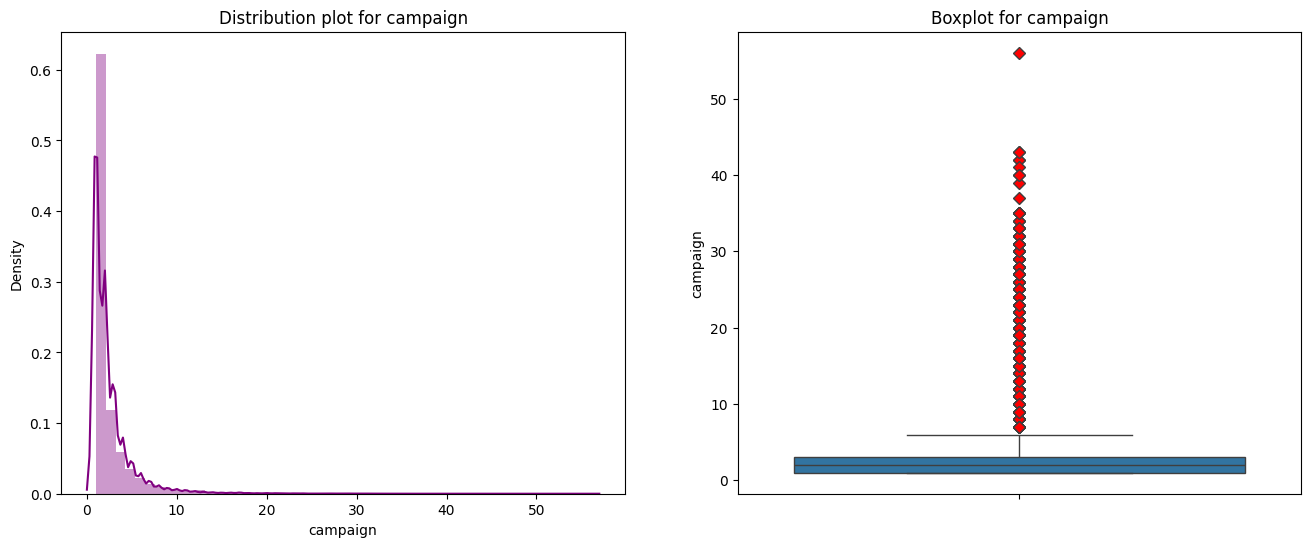

In [7]:
dist_box(df,'campaign')

In [8]:
df['campaign_log'] = np.log1p(df['campaign'])

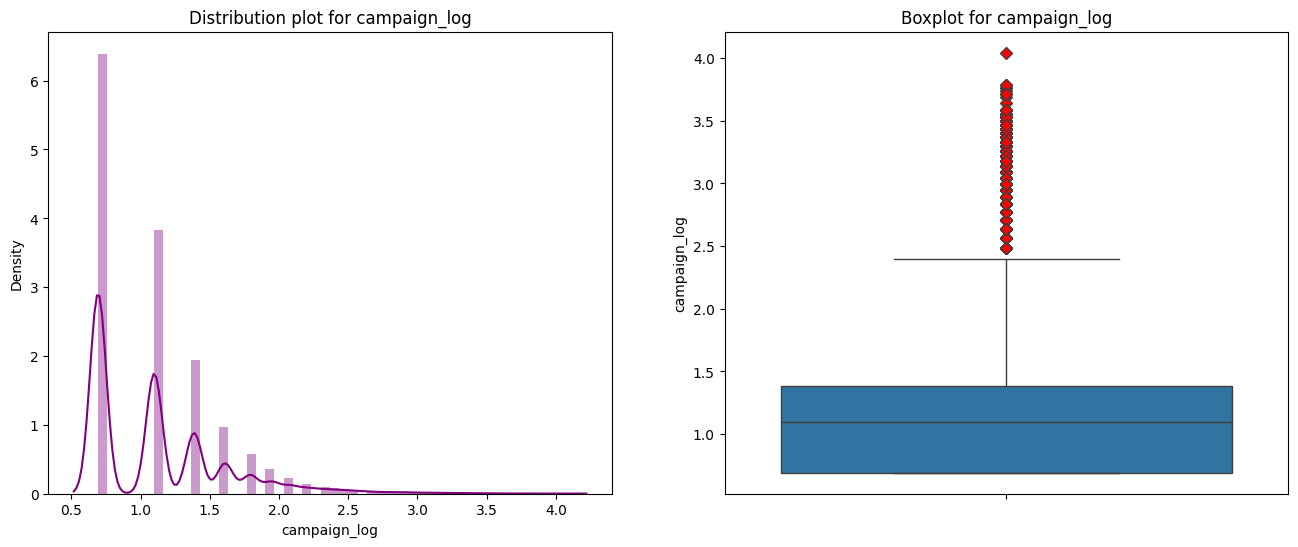

In [9]:
dist_box(df,'campaign_log')

**The distribution had a long tail, and applying a logarithmic transformation improved it somewhat.**

In [10]:
# 1) option with NaN
df['pdays_nan'] = df['pdays'].replace(999, np.nan)

# 2) option with 0
df['pdays_zero'] = df['pdays'].replace(999, 0)

# 3) binary indicator: no previous contact
df['no_prev_contact'] = (df['pdays'] == 999).astype(int)

In [11]:
def age_cat(years):
    if years <= 20:
        return '0-20'
    elif years > 20 and years <= 30:
        return '20-30'
    elif years > 30 and years <= 40:
        return '30-40'
    elif years > 40 and years <= 50:
        return '40-50'
    elif years > 50 and years <= 60:
        return '50-60'
    elif years > 60 and years <= 70:
        return '60-70'
    elif years > 70:
        return '70+'

In [12]:
# categorizing age

df['age_cats'] = df['age'].apply(age_cat)
df['age_cats'].value_counts().sort_values(ascending = False)

age_cats
30-40    16385
40-50    10240
20-30     7243
50-60     6270
60-70      488
70+        422
0-20       140
Name: count, dtype: int64

In [13]:
def bi_cat_countplot(df, column, hue_column):
    unique_hue_values = df[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,6)

    pltname = f'Normalized distribution of values by category: {column}'
    proportions = df.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[0], title=pltname)

    # annotation of values in the bar plot
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

    pltname = f'Number of records per category: {column}'
    counts = df.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container)


def uni_cat_target_compare(df, column):
    bi_cat_countplot(df, column, hue_column='y')


def bi_countplot_target(df0, df1, column, hue_column):
  pltname = 'Clients who subscribed to a term deposit'
  print(pltname.upper())
  bi_cat_countplot(df1, column, hue_column)
  plt.show()

  pltname = 'Clients who did not subscribe to a term deposit'
  print(pltname.upper())
  bi_cat_countplot(df0, column, hue_column)
  plt.show()

In [14]:
# categorical features
cat_cols = df.select_dtypes(include = "object").columns

for col in cat_cols:
    print("="*40)
    print(f"Column: {col}")
    print(df[col].value_counts(normalize = True) * 100)
    print("\n")

Column: job
job
admin.          25.30
blue-collar     22.47
technician      16.37
services         9.64
management       7.10
retired          4.18
entrepreneur     3.54
self-employed    3.45
housemaid        2.57
unemployed       2.46
student          2.12
unknown          0.80
Name: proportion, dtype: float64


Column: marital
marital
married    60.52
single     28.09
divorced   11.20
unknown     0.19
Name: proportion, dtype: float64


Column: education
education
university.degree     29.54
high.school           23.10
basic.9y              14.68
professional.course   12.73
basic.4y              10.14
basic.6y               5.56
unknown                4.20
illiterate             0.04
Name: proportion, dtype: float64


Column: default
default
no        79.12
unknown   20.87
yes        0.01
Name: proportion, dtype: float64


Column: housing
housing
yes       52.38
no        45.21
unknown    2.40
Name: proportion, dtype: float64


Column: loan
loan
no        82.43
yes       15.17
unknown

- **one-hot encoding for all categorical features**

- **merging values (education: basic.* → basic; unknown grouped in some cases)**

In [15]:
df['education'] = df['education'].replace({
    'basic.4y': 'basic',
    'basic.6y': 'basic',
    'basic.9y': 'basic',
})

# default dropped due to lack of informativeness
df = df.drop(columns=['default'])

In [16]:
def handle_unknowns(df, threshold: float = 0.03):
    """
    If the share of 'unknown' is below a threshold, replacing it with the most frequent category. 
    Otherwise, leaving it as is.
    """
    cat_cols = df.select_dtypes(exclude=[np.number]).columns

    for col in cat_cols:
        if "unknown" in df[col].values:
            freq = df[col].value_counts(normalize=True)
            unk_share = freq["unknown"]
            if unk_share < threshold:
                dominant = freq.drop("unknown").idxmax()
                df[col] = df[col].replace("unknown", dominant)
                print(f"{col}: 'unknown' ({unk_share:.2%}) → {dominant}")
            else:
                print(f"{col}: leave 'unknown' ({unk_share:.2%})")

    return df

In [17]:
df = handle_unknowns(df, threshold=0.03)

job: 'unknown' (0.80%) → admin.
marital: 'unknown' (0.19%) → married
education: leave 'unknown' (4.20%)
housing: 'unknown' (2.40%) → yes
loan: 'unknown' (2.40%) → no


In [18]:
# target column 'y'
df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [19]:
df['y'].value_counts(normalize = True).sort_values(ascending = False) * 100

y
0   88.73
1   11.27
Name: proportion, dtype: float64

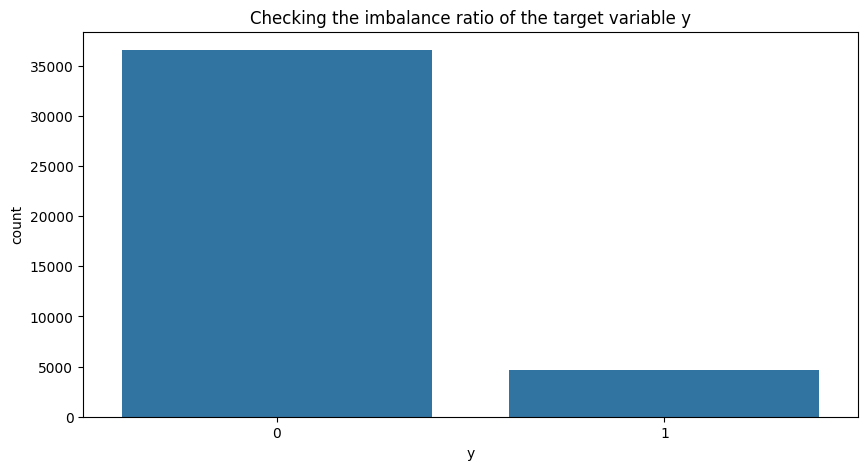

In [20]:
plt.figure(figsize = (10,5))
sns.countplot(x = df['y'], data = df)
plt.title('Checking the imbalance ratio of the target variable y')
plt.show()

- **the target variable y is imbalanced based on the percentage of observations**
- **y = 1 (client subscribed to a term deposit): only 11.27% of the data**
- **y = 0 (client did not subscribe): 88.73% of the data"**

In [21]:
df1 = df[df['y'] == 1]
df0 = df[df['y'] == 0]

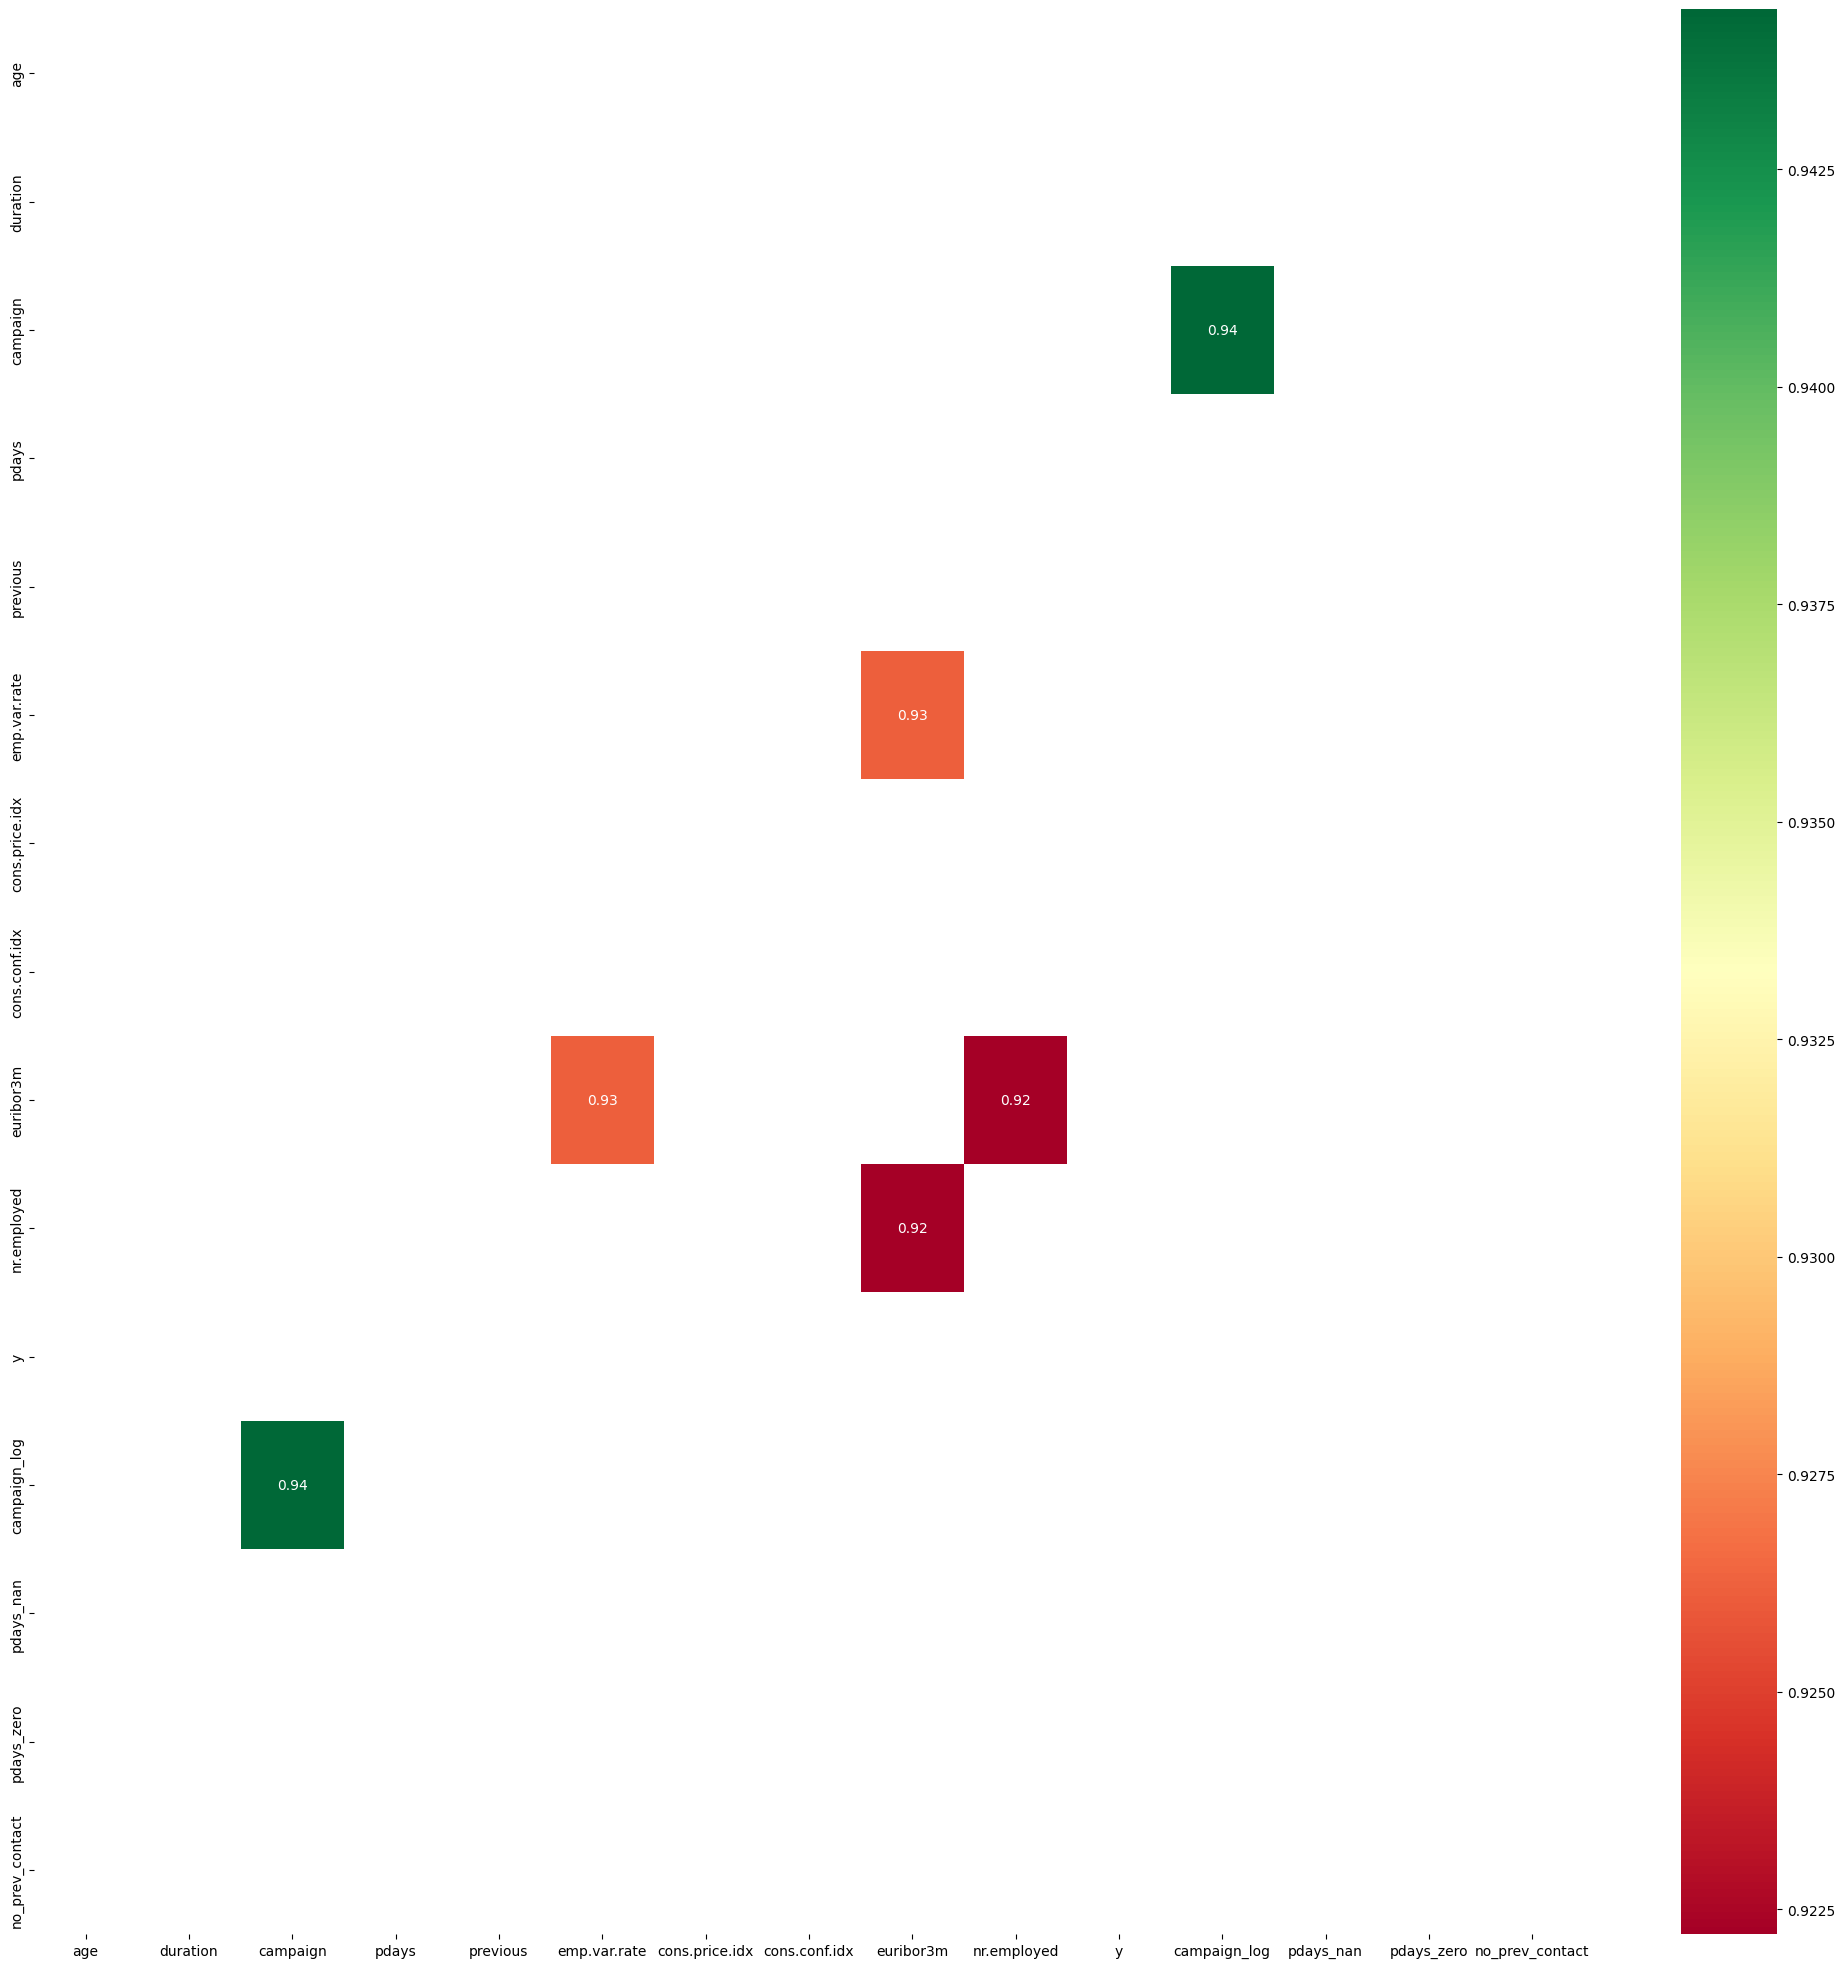

campaign         campaign_log      0.94
campaign_log     campaign          0.94
emp.var.rate     euribor3m         0.93
euribor3m        emp.var.rate      0.93
nr.employed      euribor3m         0.92
euribor3m        nr.employed       0.92
emp.var.rate     nr.employed       0.79
nr.employed      emp.var.rate      0.79
cons.price.idx   emp.var.rate      0.66
emp.var.rate     cons.price.idx    0.66
pdays_zero       previous          0.57
previous         pdays_zero        0.57
emp.var.rate     duration          0.50
duration         emp.var.rate      0.50
euribor3m        duration          0.50
duration         euribor3m         0.50
                 nr.employed       0.48
nr.employed      duration          0.48
                 no_prev_contact   0.45
no_prev_contact  nr.employed       0.45
pdays            nr.employed       0.45
nr.employed      pdays             0.45
dtype: float64

In [22]:
# correlation analysis of numerical variables

corr_df1 = df1.select_dtypes(include=["int64","float64"]).corr()

plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1[(corr_df1 >= 0.8) & (corr_df1 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

corr_df1[corr_df1 <= 0.99].unstack().sort_values(ascending = False).head(22)

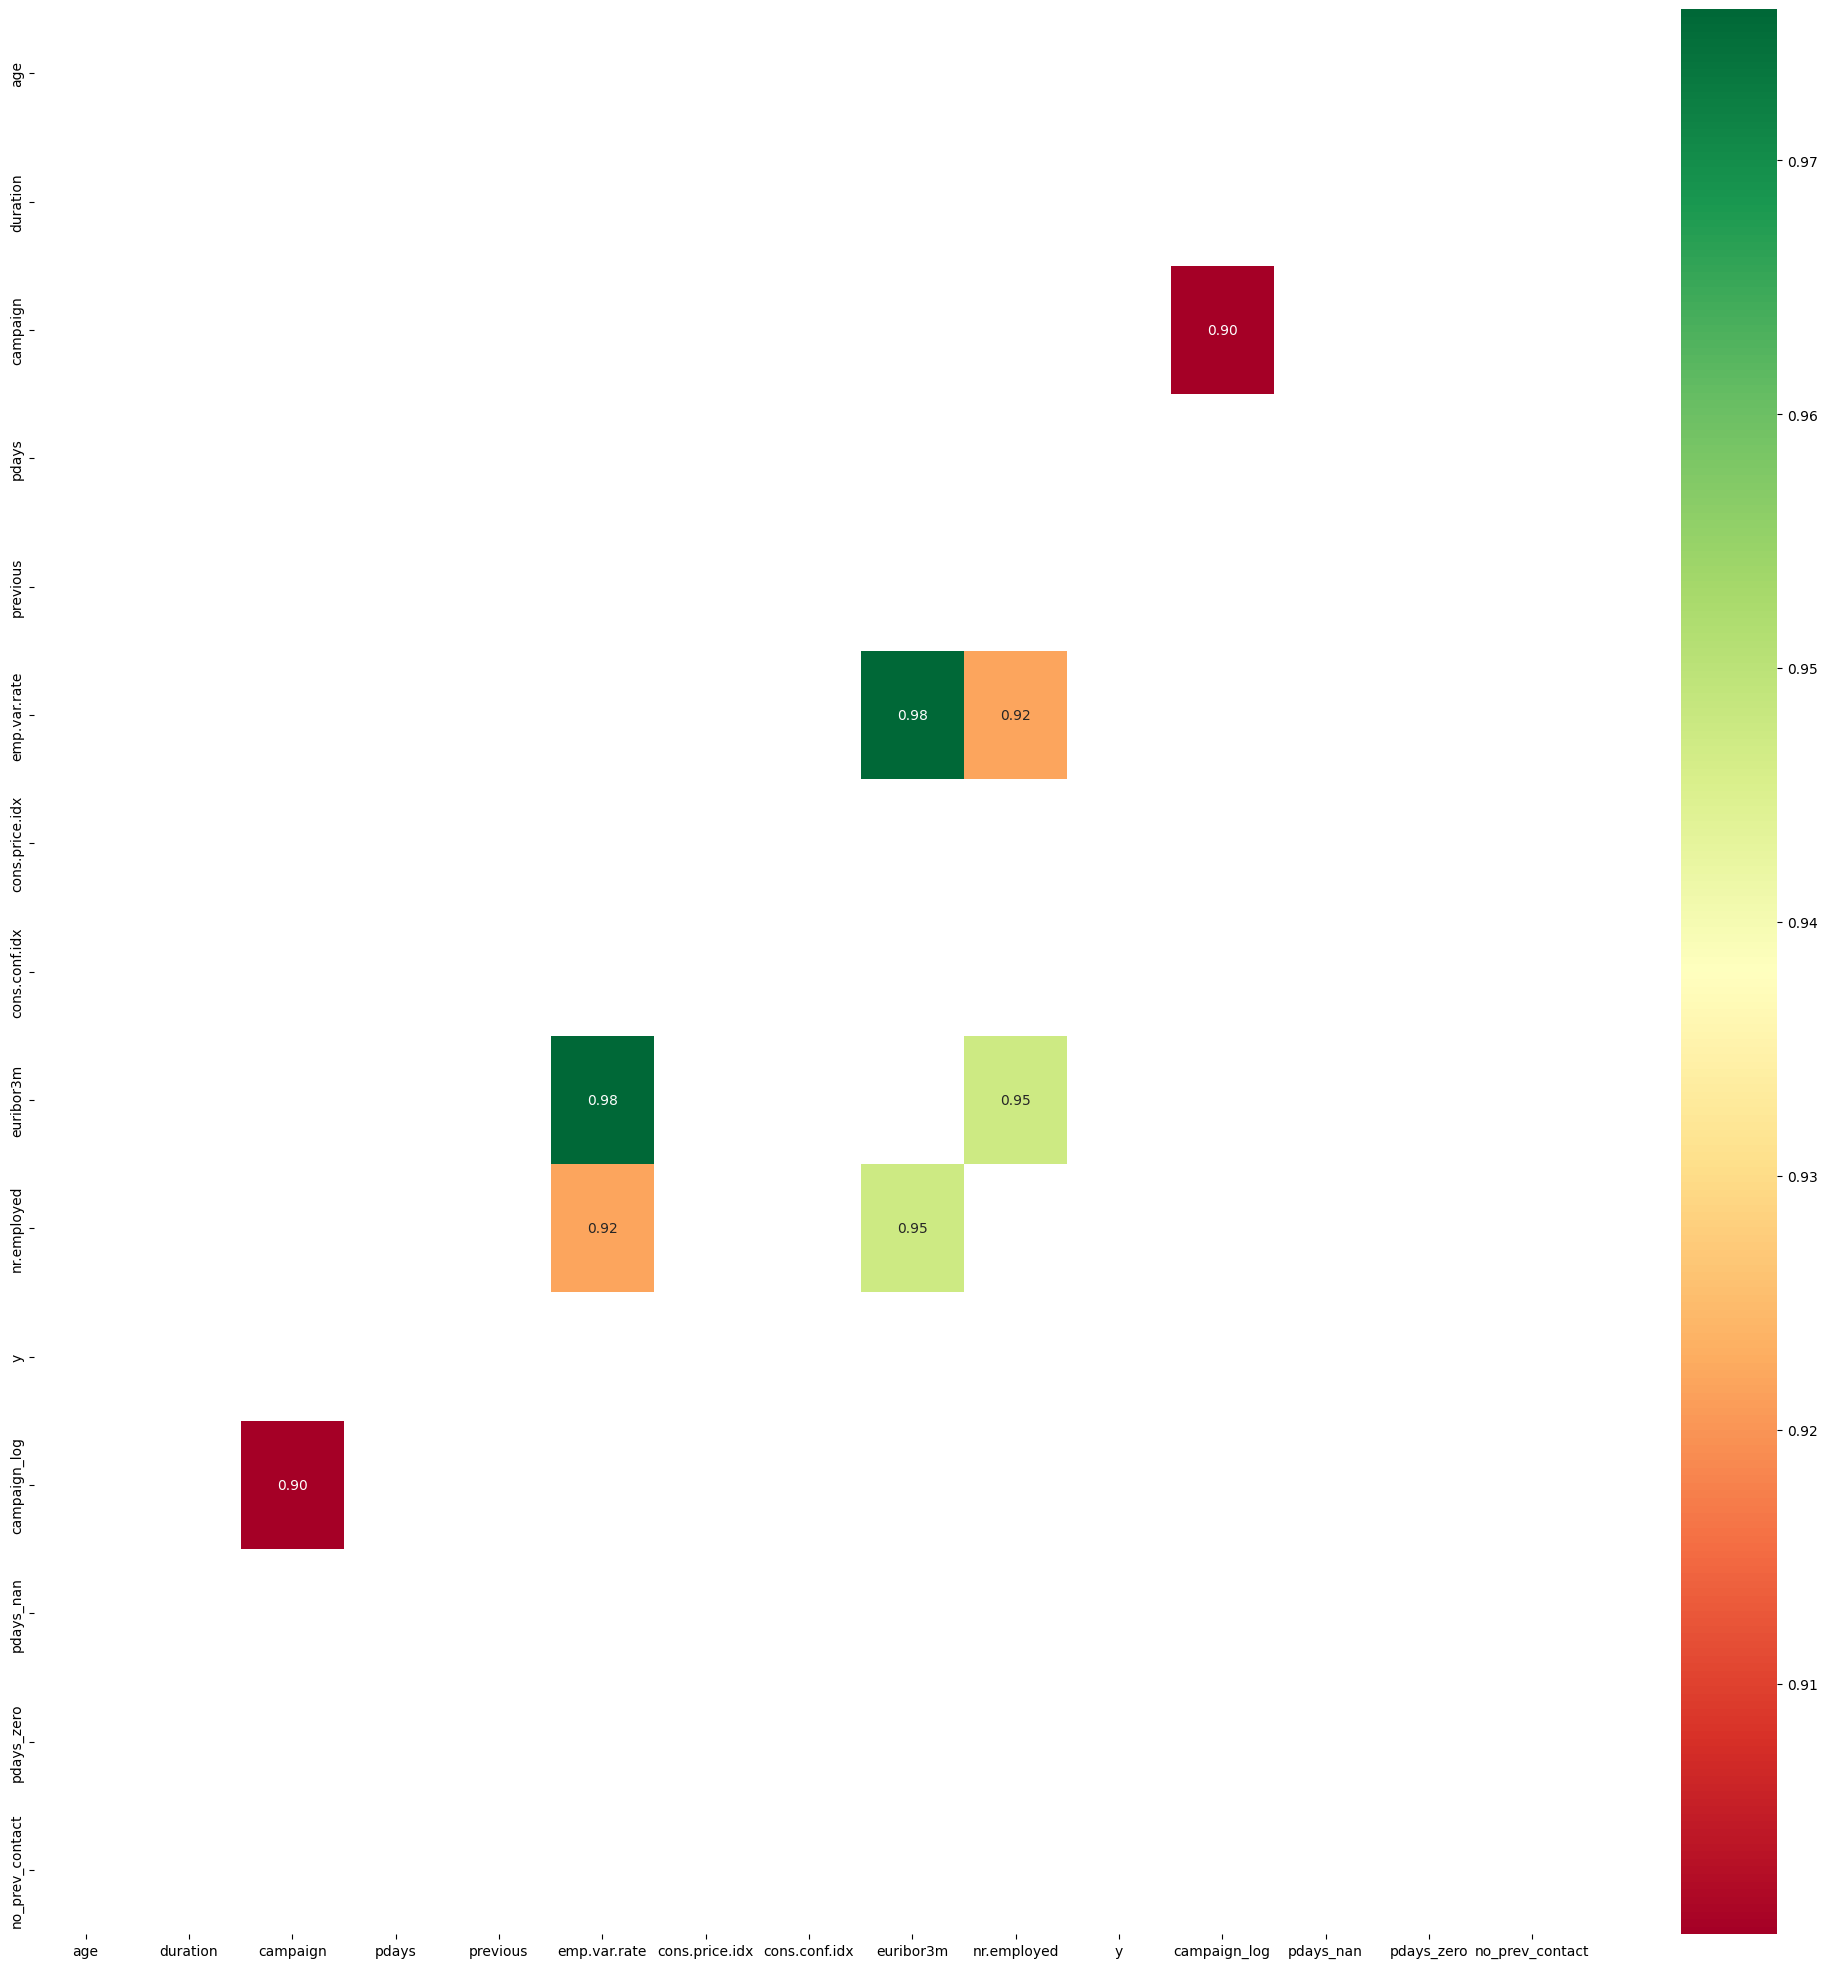

emp.var.rate     euribor3m         0.98
euribor3m        emp.var.rate      0.98
nr.employed      euribor3m         0.95
euribor3m        nr.employed       0.95
emp.var.rate     nr.employed       0.92
nr.employed      emp.var.rate      0.92
campaign_log     campaign          0.90
campaign         campaign_log      0.90
emp.var.rate     cons.price.idx    0.80
cons.price.idx   emp.var.rate      0.80
                 euribor3m         0.73
euribor3m        cons.price.idx    0.73
cons.price.idx   nr.employed       0.59
nr.employed      cons.price.idx    0.59
euribor3m        cons.conf.idx     0.39
cons.conf.idx    euribor3m         0.39
previous         pdays_zero        0.37
pdays_zero       previous          0.37
emp.var.rate     cons.conf.idx     0.32
cons.conf.idx    emp.var.rate      0.32
no_prev_contact  nr.employed       0.24
nr.employed      no_prev_contact   0.24
                 pdays             0.24
pdays            nr.employed       0.24
pdays_nan        cons.price.idx    0.22


In [23]:
corr_df0 = df0.select_dtypes(include=["int64","float64"]).corr()

plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df0[(corr_df0 >= 0.8) & (corr_df0 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

corr_df0[corr_df0 <= 0.99].unstack().sort_values(ascending = False).head(28)

**There is strong multicollinearity among the macroeconomic variables: emp.var.rate, euribor3m, and nr.employed essentially duplicate one another. For Logistic Regression, it is advisable to perform feature selection or apply regularization (L1/L2).**

In [24]:
def univariate_outlier_analysis(df0, df1, column):
    print(f"\n=== Variable analysis: {column} ===")

    # for df1 — subscribed to a term deposit
    Q1_1 = df1[column].quantile(0.25)
    Q3_1 = df1[column].quantile(0.75)
    IQR_1 = Q3_1 - Q1_1
    Min_value1 = Q1_1 - 1.5 * IQR_1
    Max_value1 = Q3_1 + 1.5 * IQR_1

    print(f"[df1 - signed] IQR = {IQR_1}")
    print(f"Minimum value where outliers appear: {Min_value1}")
    print(f"Maximum value beyond which outliers appear: {Max_value1}")

    # for df0 — did not subscribe to a term deposit
    Q1_0 = df0[column].quantile(0.25)
    Q3_0 = df0[column].quantile(0.75)
    IQR_0 = Q3_0 - Q1_0
    Min_value0 = Q1_0 - 1.5 * IQR_0
    Max_value0 = Q3_0 + 1.5 * IQR_0

    print(f"[df0 - did not sign] IQR = {IQR_0}")
    print(f"Minimum value where outliers appear: {Min_value0}")
    print(f"Maximum value beyond which outliers appear: {Max_value0}")

    # KDE without ooultiers
    plt.figure(figsize=(14, 6))
    sns.kdeplot(df1[df1[column] <= Max_value1][column], label='Signed')
    sns.kdeplot(df0[df0[column] <= Max_value0][column], label='Did not Sign')
    plt.ticklabel_format(style='plain', axis='x')
    plt.xticks(rotation=45)
    plt.title(f"KDE without outliers for: {column}")
    plt.legend()
    plt.show()


=== Variable analysis: age ===
[df1 - signed] IQR = 19.0
Minimum value where outliers appear: 2.5
Maximum value beyond which outliers appear: 78.5
[df0 - did not sign] IQR = 15.0
Minimum value where outliers appear: 9.5
Maximum value beyond which outliers appear: 69.5


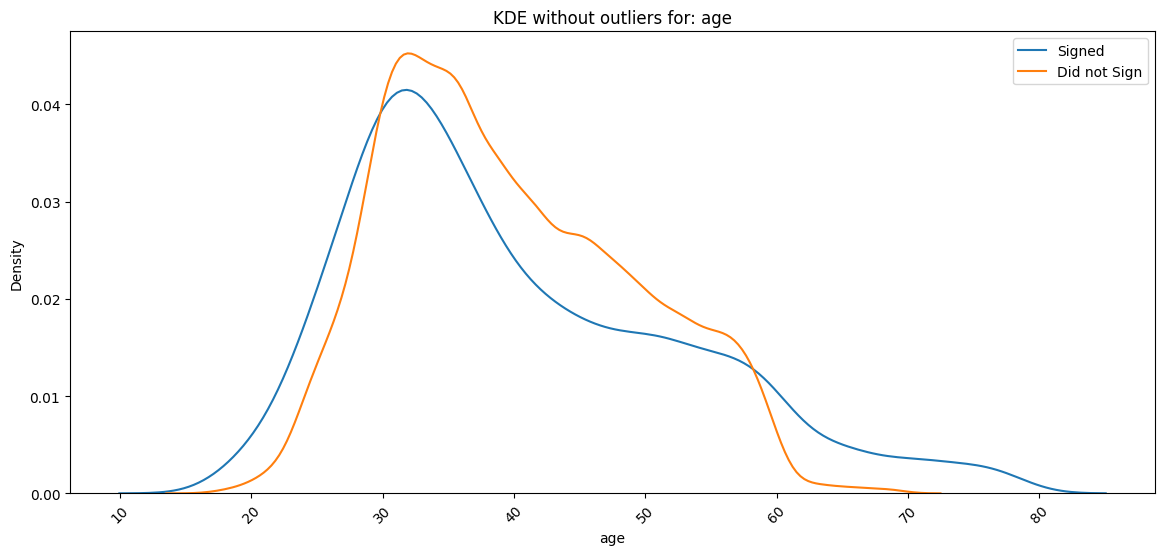


=== Variable analysis: duration ===
[df1 - signed] IQR = 488.25
Minimum value where outliers appear: -479.375
Maximum value beyond which outliers appear: 1473.625
[df0 - did not sign] IQR = 184.0
Minimum value where outliers appear: -181.0
Maximum value beyond which outliers appear: 555.0


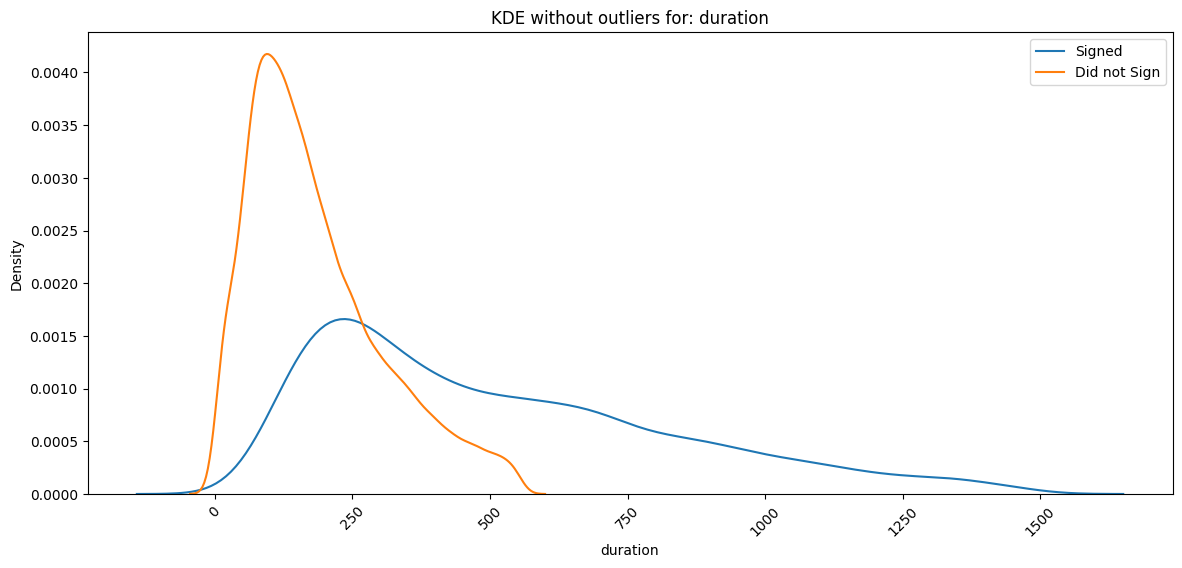


=== Variable analysis: campaign ===
[df1 - signed] IQR = 1.0
Minimum value where outliers appear: -0.5
Maximum value beyond which outliers appear: 3.5
[df0 - did not sign] IQR = 2.0
Minimum value where outliers appear: -2.0
Maximum value beyond which outliers appear: 6.0


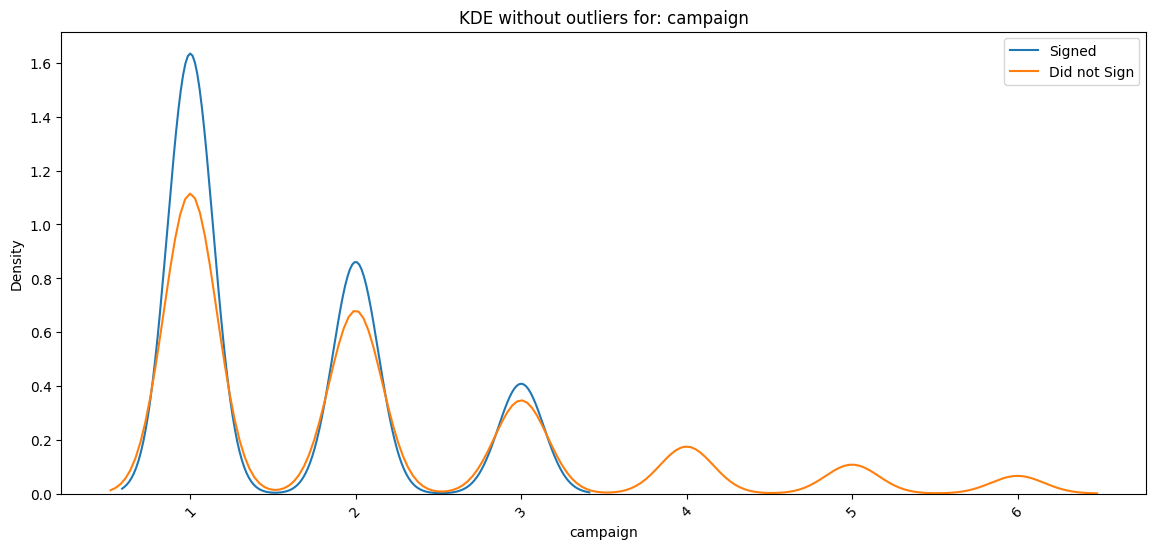


=== Variable analysis: pdays ===
[df1 - signed] IQR = 0.0
Minimum value where outliers appear: 999.0
Maximum value beyond which outliers appear: 999.0
[df0 - did not sign] IQR = 0.0
Minimum value where outliers appear: 999.0
Maximum value beyond which outliers appear: 999.0


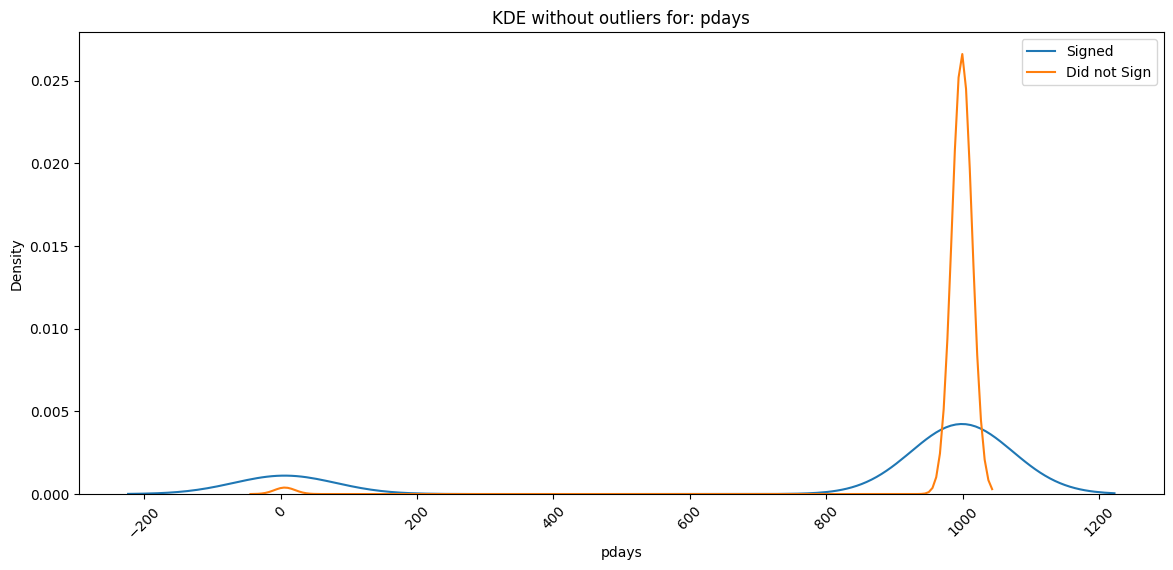


=== Variable analysis: previous ===
[df1 - signed] IQR = 1.0
Minimum value where outliers appear: -1.5
Maximum value beyond which outliers appear: 2.5
[df0 - did not sign] IQR = 0.0
Minimum value where outliers appear: 0.0
Maximum value beyond which outliers appear: 0.0


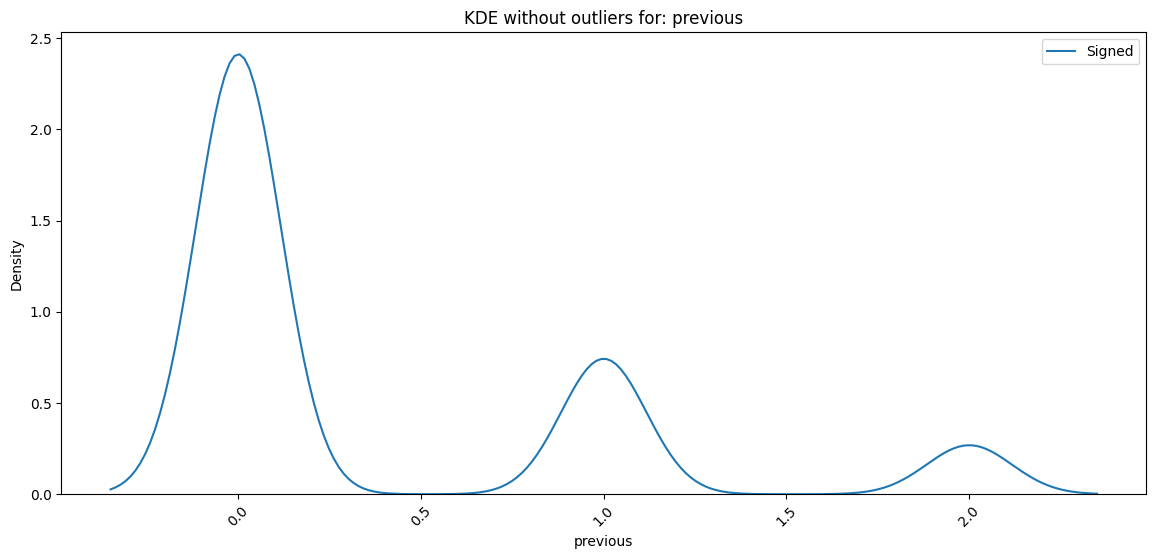


=== Variable analysis: emp.var.rate ===
[df1 - signed] IQR = 1.7
Minimum value where outliers appear: -4.35
Maximum value beyond which outliers appear: 2.4499999999999997
[df0 - did not sign] IQR = 3.2
Minimum value where outliers appear: -6.6000000000000005
Maximum value beyond which outliers appear: 6.200000000000001


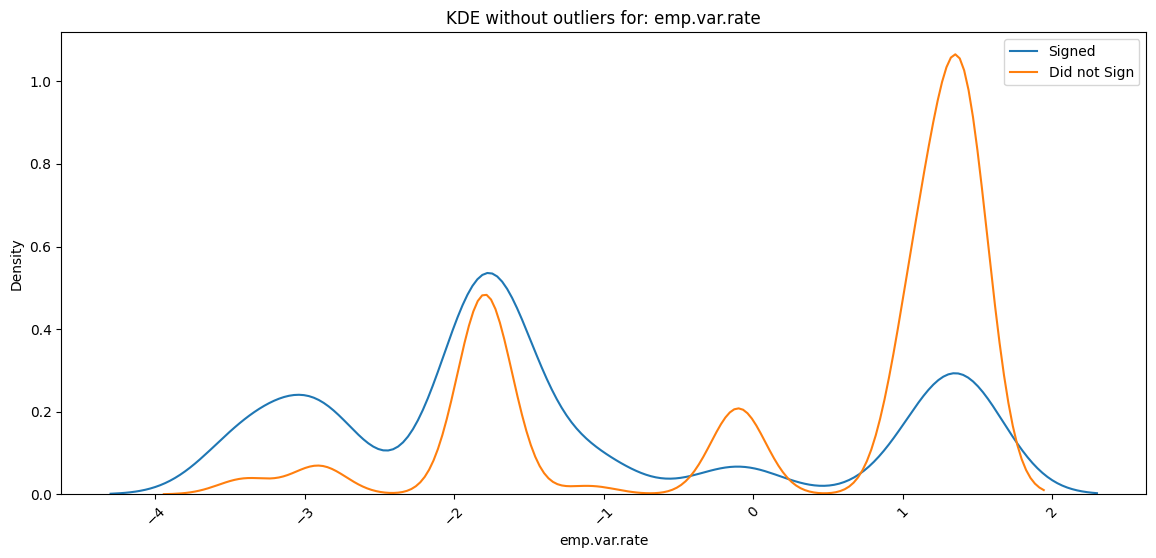


=== Variable analysis: cons.price.idx ===
[df1 - signed] IQR = 1.0250000000000057
Minimum value where outliers appear: 91.35549999999999
Maximum value beyond which outliers appear: 95.45550000000001
[df0 - did not sign] IQR = 0.9189999999999969
Minimum value where outliers appear: 91.69650000000001
Maximum value beyond which outliers appear: 95.3725


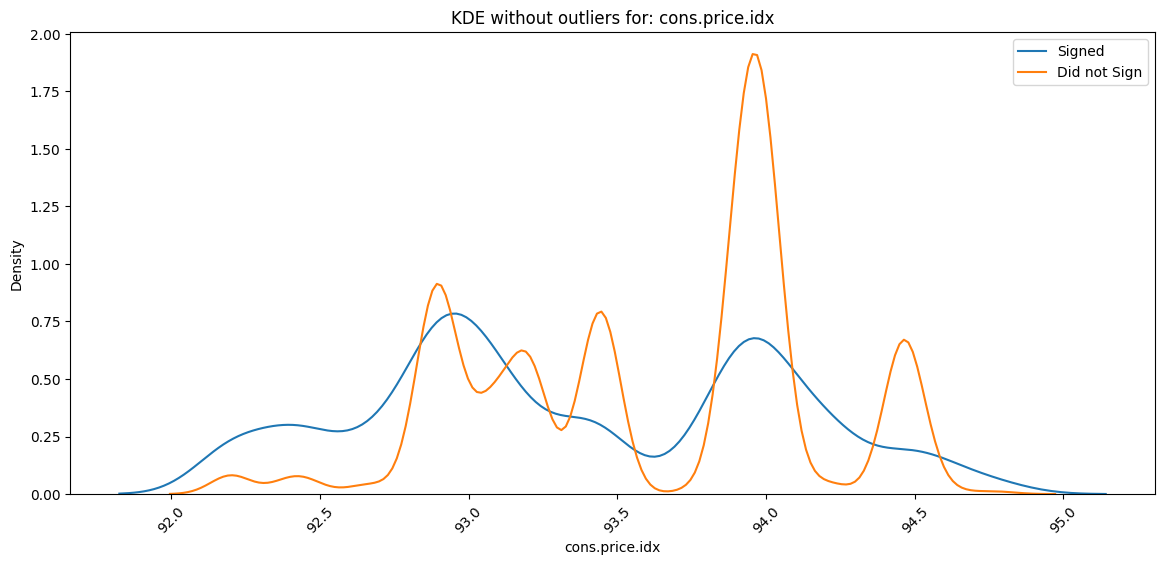


=== Variable analysis: cons.conf.idx ===
[df1 - signed] IQR = 10.100000000000001
Minimum value where outliers appear: -61.35000000000001
Maximum value beyond which outliers appear: -20.95
[df0 - did not sign] IQR = 6.300000000000004
Minimum value where outliers appear: -52.150000000000006
Maximum value beyond which outliers appear: -26.949999999999992


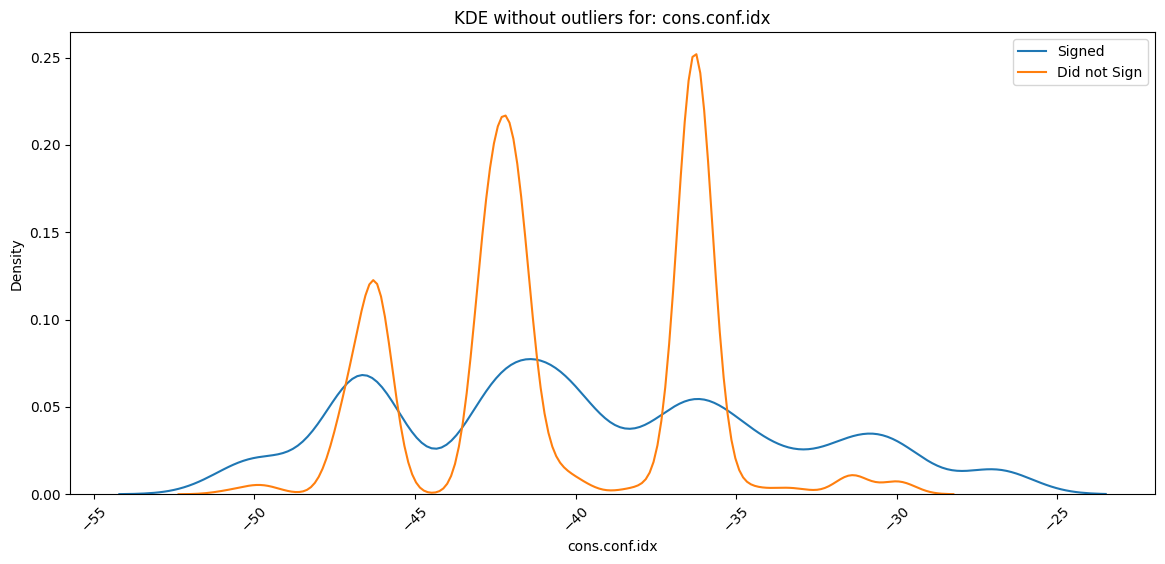


=== Variable analysis: euribor3m ===
[df1 - signed] IQR = 3.5569999999999995
Minimum value where outliers appear: -4.4864999999999995
Maximum value beyond which outliers appear: 9.741499999999998
[df0 - did not sign] IQR = 3.5569999999999995
Minimum value where outliers appear: -3.9304999999999994
Maximum value beyond which outliers appear: 10.2975


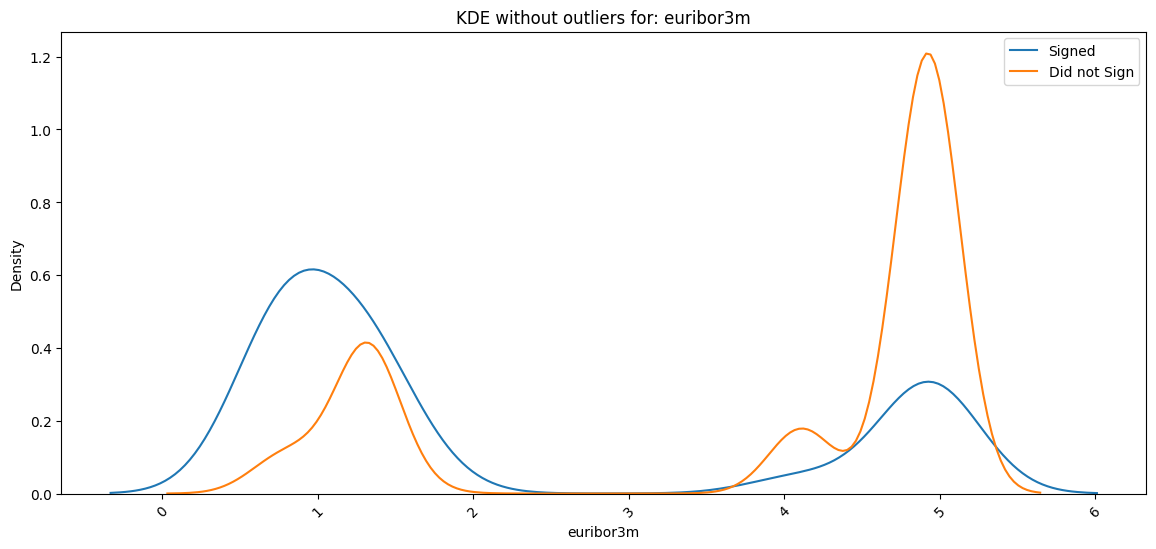


=== Variable analysis: nr.employed ===
[df1 - signed] IQR = 173.5
Minimum value where outliers appear: 4757.25
Maximum value beyond which outliers appear: 5451.25
[df0 - did not sign] IQR = 129.0
Minimum value where outliers appear: 4905.6
Maximum value beyond which outliers appear: 5421.6


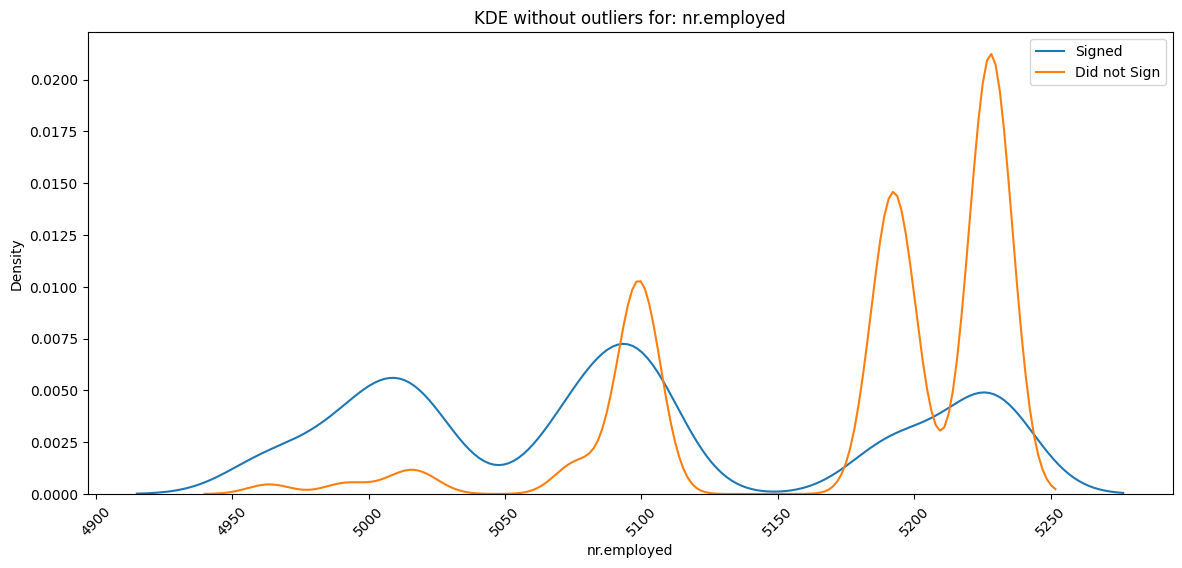


=== Variable analysis: campaign_log ===
[df1 - signed] IQR = 0.4054651081081645
Minimum value where outliers appear: 0.0849495183976986
Maximum value beyond which outliers appear: 1.7068099508303565
[df0 - did not sign] IQR = 0.6931471805599453
Minimum value where outliers appear: -0.3465735902799726
Maximum value beyond which outliers appear: 2.4260151319598084


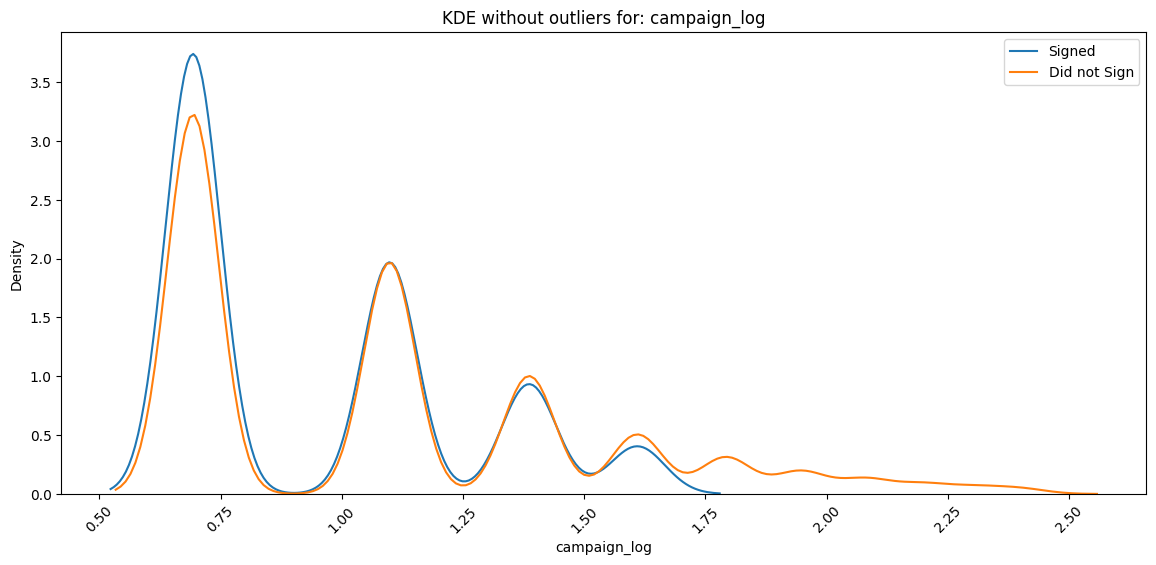


=== Variable analysis: pdays_nan ===
[df1 - signed] IQR = 3.0
Minimum value where outliers appear: -1.5
Maximum value beyond which outliers appear: 10.5
[df0 - did not sign] IQR = 6.0
Minimum value where outliers appear: -6.0
Maximum value beyond which outliers appear: 18.0


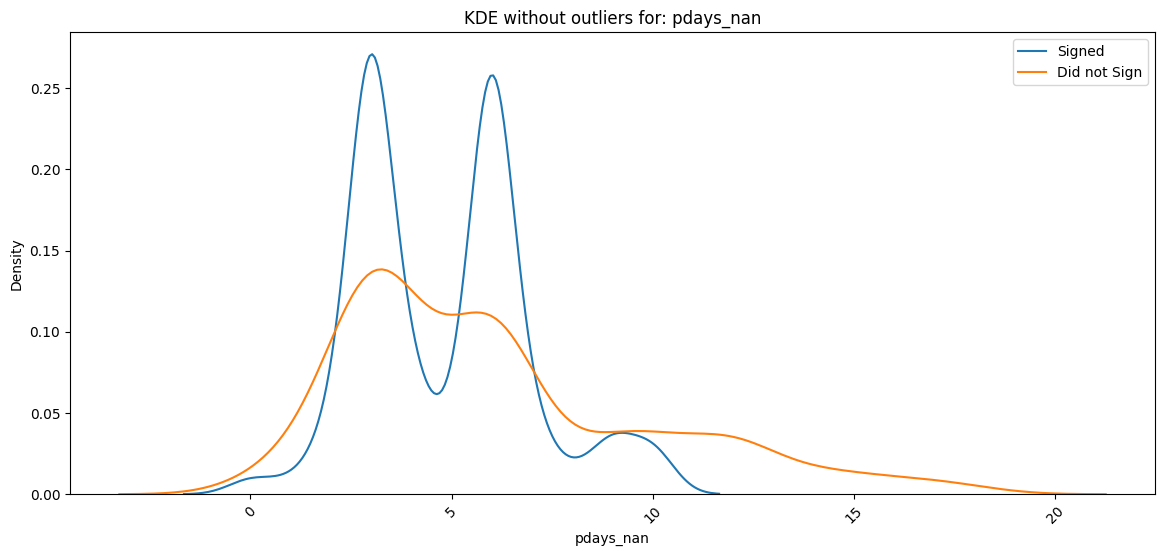


=== Variable analysis: pdays_zero ===
[df1 - signed] IQR = 0.0
Minimum value where outliers appear: 0.0
Maximum value beyond which outliers appear: 0.0
[df0 - did not sign] IQR = 0.0
Minimum value where outliers appear: 0.0
Maximum value beyond which outliers appear: 0.0


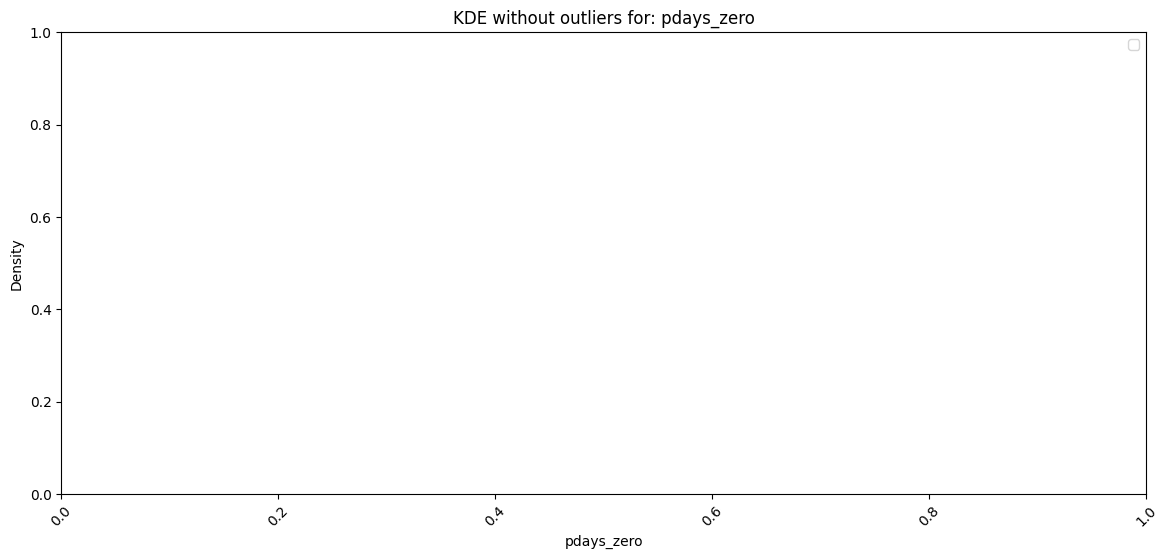


=== Variable analysis: no_prev_contact ===
[df1 - signed] IQR = 0.0
Minimum value where outliers appear: 1.0
Maximum value beyond which outliers appear: 1.0
[df0 - did not sign] IQR = 0.0
Minimum value where outliers appear: 1.0
Maximum value beyond which outliers appear: 1.0


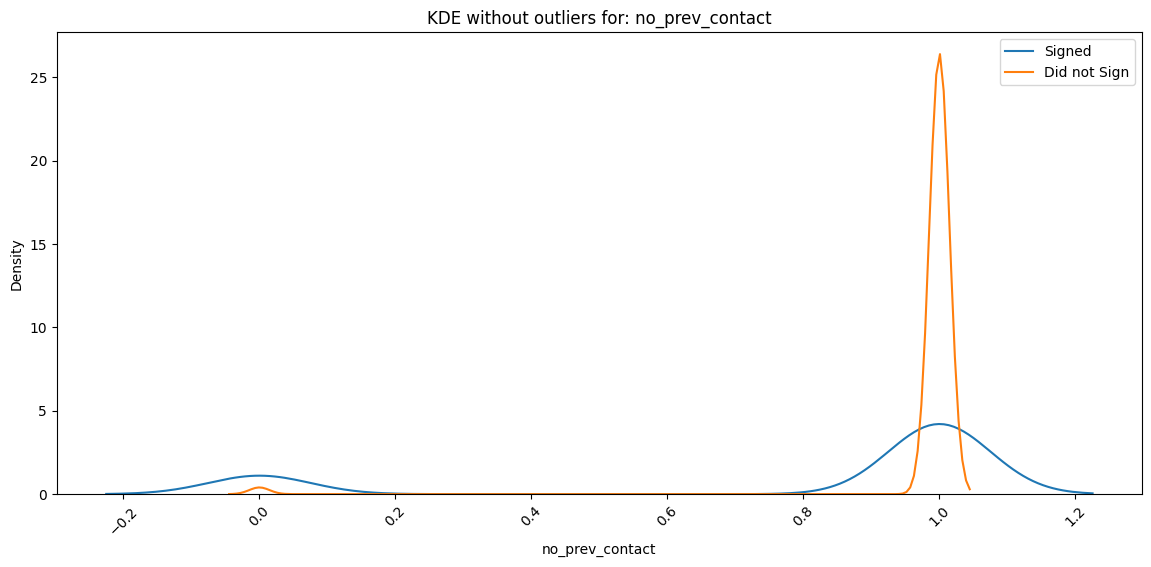

In [25]:
# univariate analysis of numerical variables

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop('y')

for col in num_cols:
    univariate_outlier_analysis(df0, df1, col)

- **For age, differences between groups are small, but there is a trend: clients aged 30–60 are less likely to subscribe.**
- **For campaign, subscribed clients are more often contacted 1–2 times.**
- **For emp.var.rate, clients were more willing to subscribe during periods of economic decline rather than growth.**
- **For euribor3m, lower interest rates encouraged more subscriptions.**
- **For nr.employed, fewer employed people correlated with a higher likelihood of subscriptions.**
- **For cons.price.idx, there is some effect, but less pronounced.**
- **For cons.conf.idx, lower consumer confidence slightly increased the chances of subscription.**

Analysis for a categorical variable: job


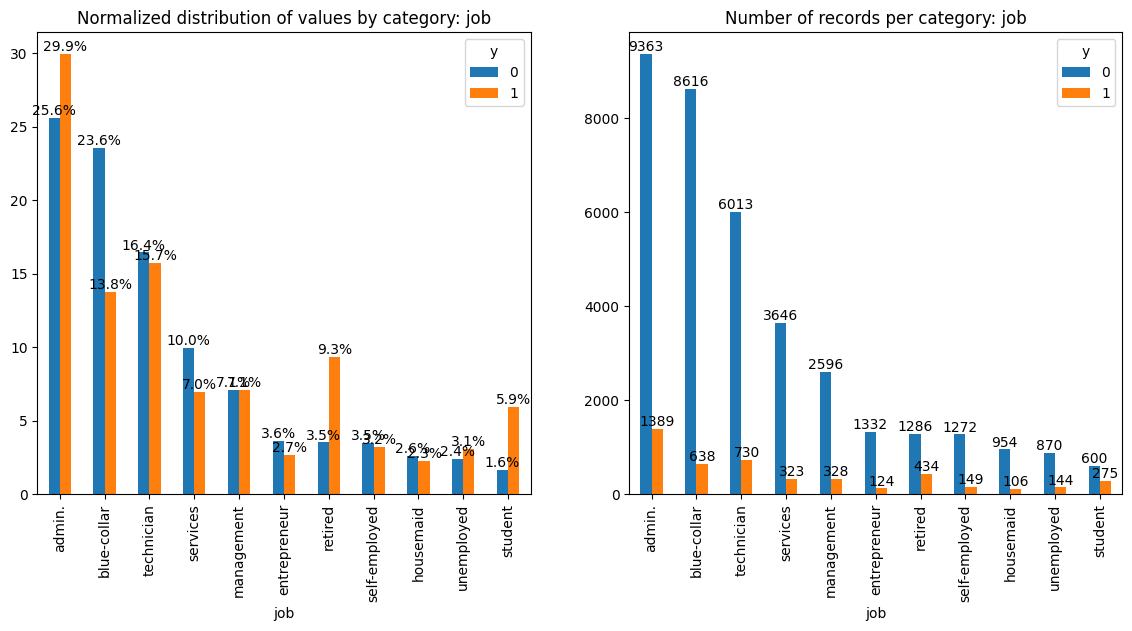

Analysis for a categorical variable: marital


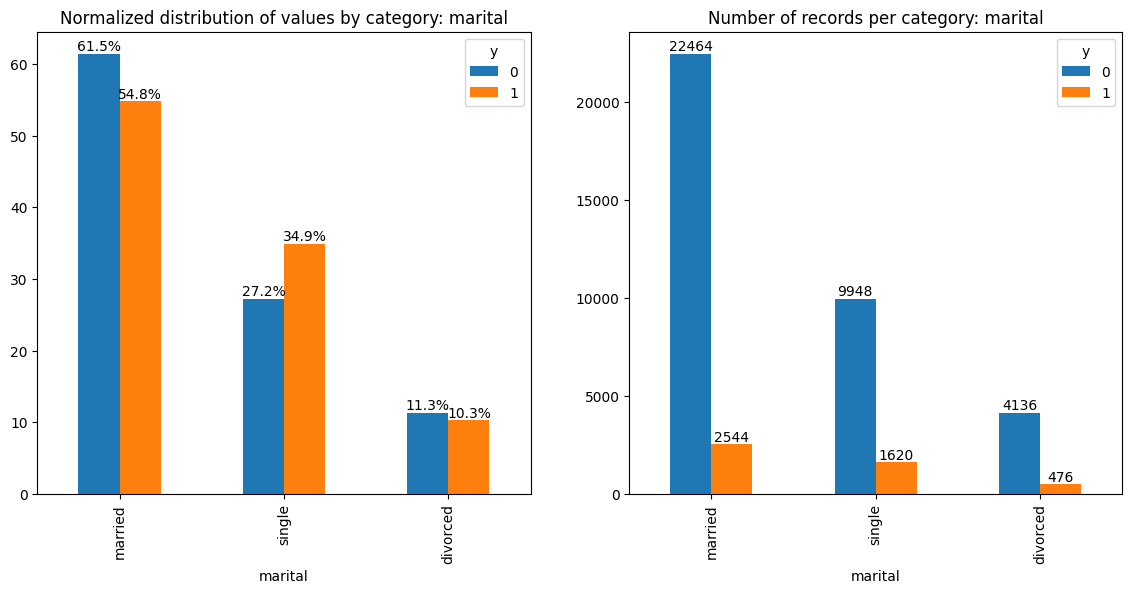

Analysis for a categorical variable: education


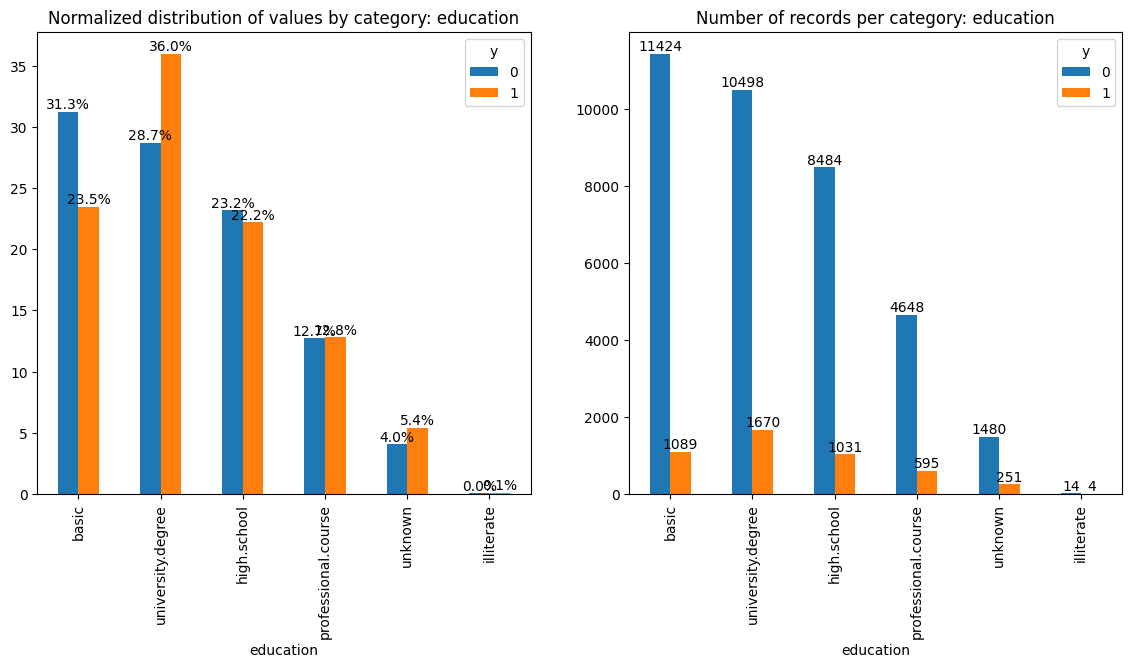

Analysis for a categorical variable: housing


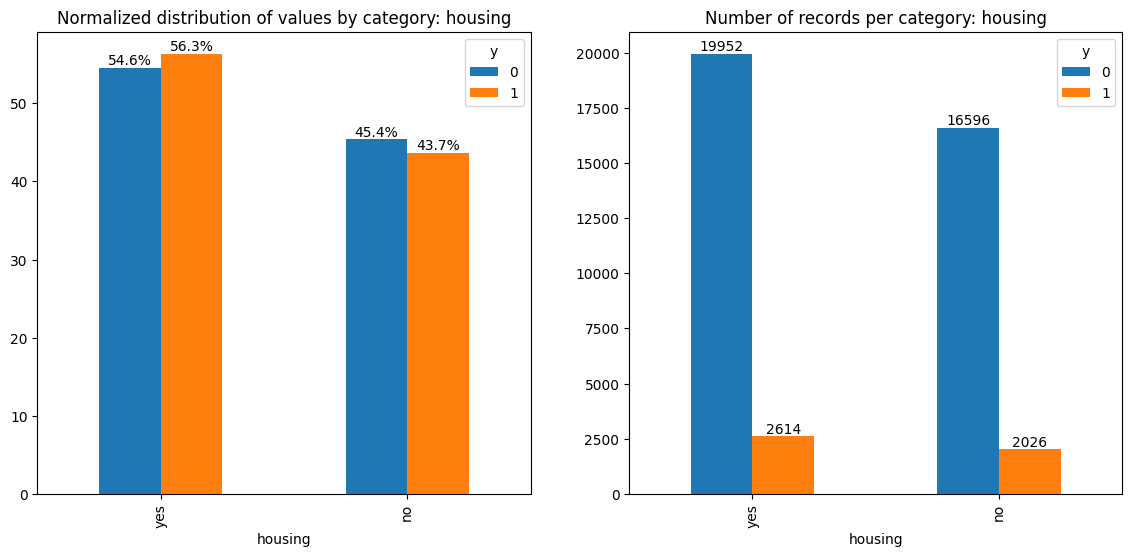

Analysis for a categorical variable: loan


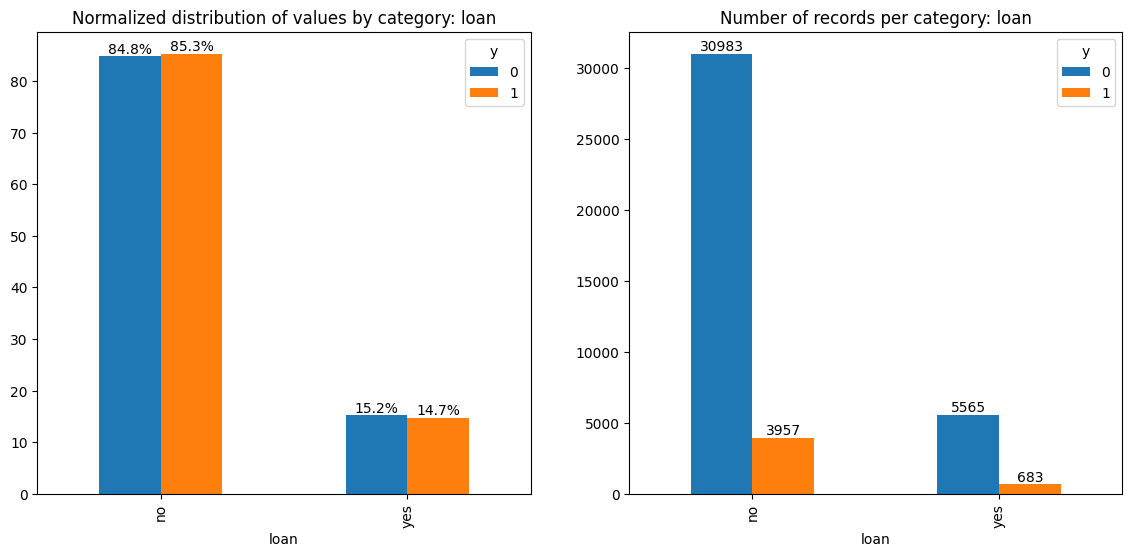

Analysis for a categorical variable: contact


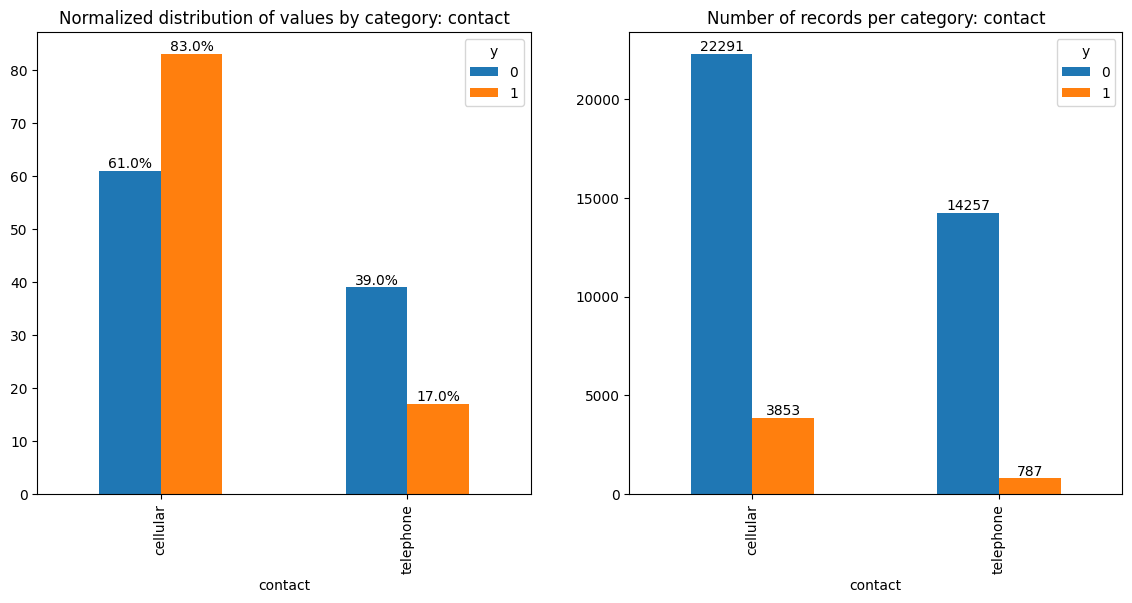

Analysis for a categorical variable: month


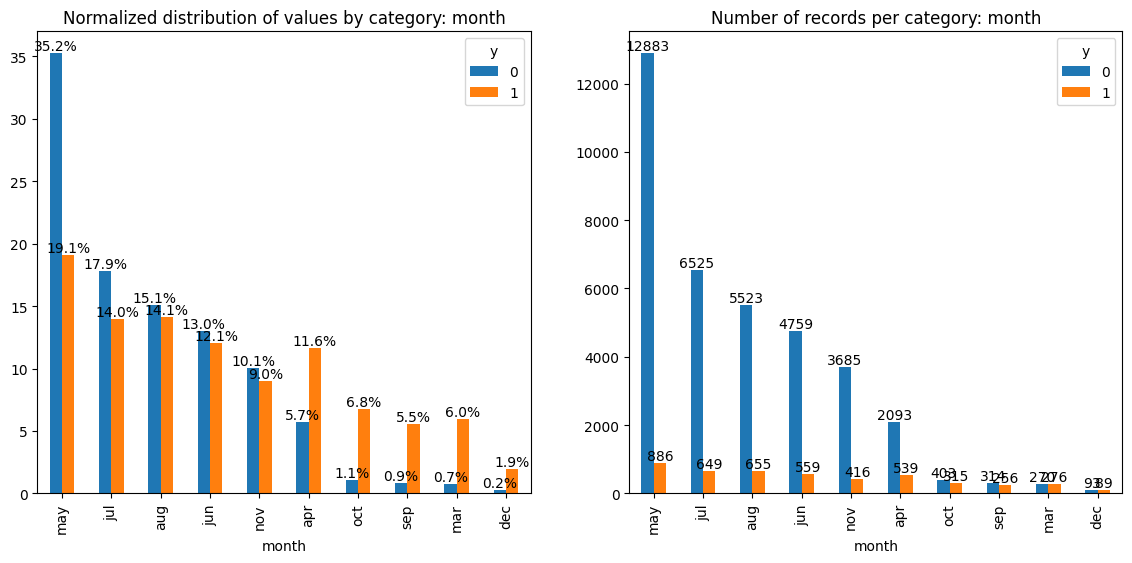

Analysis for a categorical variable: day_of_week


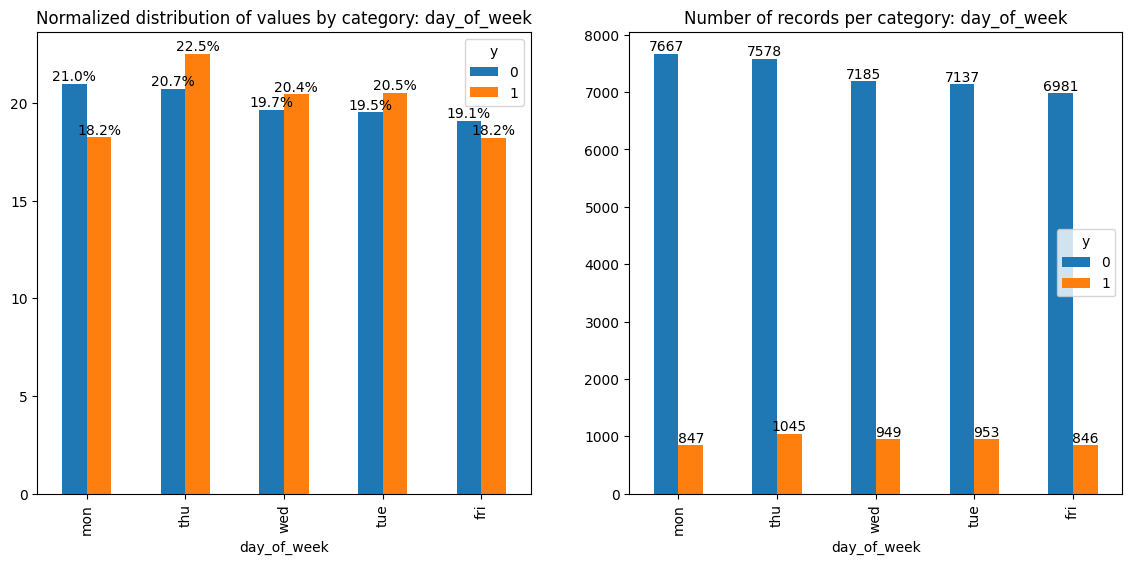

Analysis for a categorical variable: poutcome


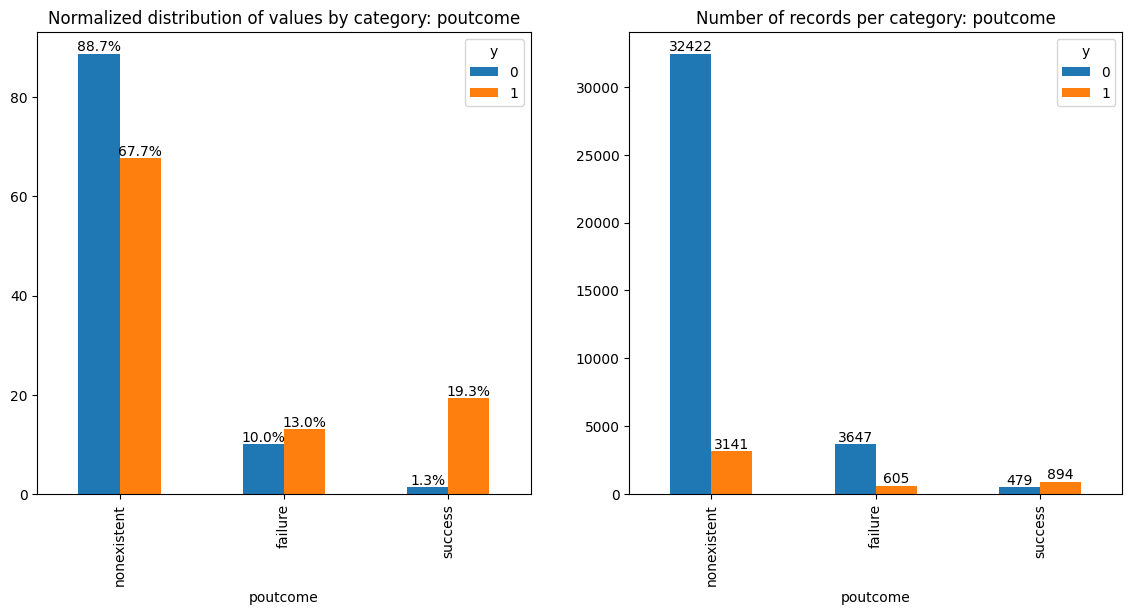

Analysis for a categorical variable: age_cats


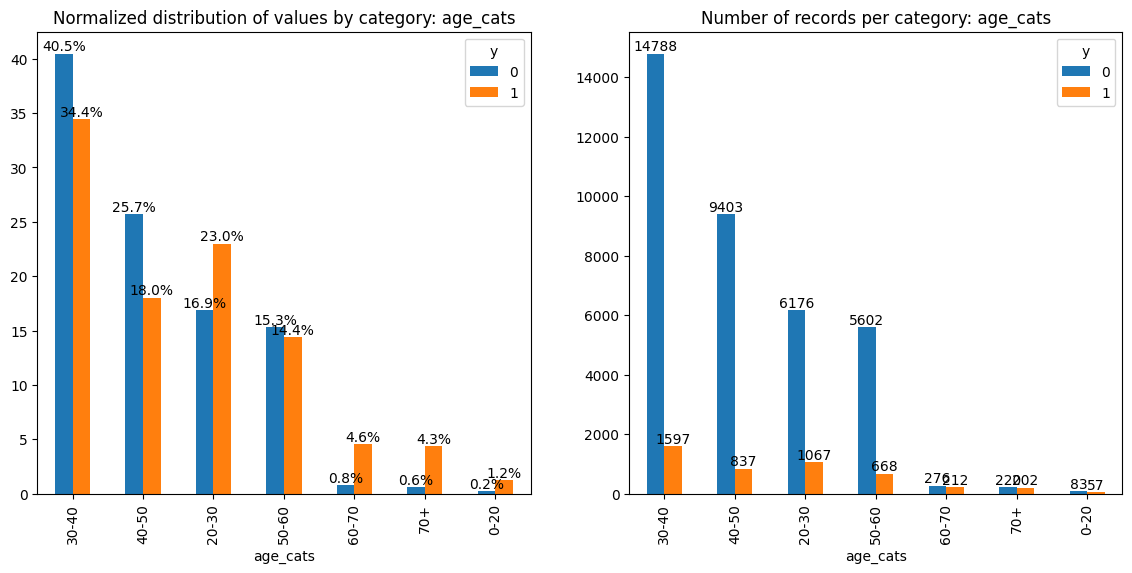

In [26]:
cat_cols2 = df.select_dtypes(include="object").columns

# univariate analysis of categorical variables

for col in cat_cols2:
    print("="*80)
    print(f"Analysis for a categorical variable: {col}")
    uni_cat_target_compare(df, col)
    plt.show()

**The most informative variables appear to be job, marital, education, contact, month, poutcome, and age_cats. These features show clear differences between clients who subscribed to a term deposit and those who did not.**

In [27]:
def outlier_range_max(df, column):
    """
    Calculates the upper bound for outliers in a column 
    using the IQR rule (Q3 + 1.5 * IQR).
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return Q3 + 1.5 * IQR

In [28]:
def draw_boxplot(df, categorical, continuous, max_continuous, title, hue_column, subplot_position):
    """
    Draws a boxplot for a given DataFrame, categorical variable, and continuous variable.
    """
    plt.subplot(1, 2, subplot_position)
    plt.title(title)
    red_diamond = dict(markerfacecolor='r', marker='D')
    sns.boxplot(x=categorical,
                y=df[df[continuous] < max_continuous][continuous],
                data=df,
                flierprops=red_diamond,
                order=sorted(df[categorical].unique(), reverse=True),
                hue=hue_column, hue_order=sorted(df[hue_column].unique(), reverse=True))
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)

def bi_boxplot(categorical, continuous, max_continuous1, max_continuous0, hue_column):
    """
    Creates parallel boxplots for two groups in the dataset, based on a categorical and a continuous variable, 
    highlighting differences with shades.
    """
    plt.figure(figsize=(16, 10))

    # plot for the first group
    draw_boxplot(df1, categorical, continuous, max_continuous1, 'Signed', hue_column, 1)

    # plot for the second group 
    draw_boxplot(df0, categorical, continuous, max_continuous0, 'Not Signed', hue_column, 2)

    plt.tight_layout(pad=4)
    plt.show()
    
def numeric_vs_categorical_analysis(df0, df1, column_1, column_2, column_3):
  max_value1_column_1 = outlier_range_max(df1, column_1)
  max_value0_column_1 = outlier_range_max(df0, column_1)

  
  display(df1.groupby(by = [column_2, column_3])[column_1].describe().head())


  display(df0.groupby(by = [column_2, column_3])[column_1].describe().head())

  bi_boxplot(column_2, column_1, max_value1_column_1, max_value0_column_1, column_3)

count  mean   std   min   25%   50%   75%   max
job         marital                                                  
admin.      divorced 135.00 45.58  9.62 28.00 39.00 45.00 52.00 81.00
            married  673.00 41.80 10.57 23.00 33.00 39.00 50.00 78.00
            single   581.00 32.34  6.96 21.00 28.00 31.00 35.00 59.00
blue-collar divorced  53.00 42.04  9.24 28.00 34.00 40.00 50.00 59.00
            married  424.00 41.33  9.19 21.00 33.00 41.00 49.00 70.00

count  mean  std   min   25%   50%   75%   max
job         marital                                                  
admin.      divorced 1158.00 43.10 8.51 25.00 36.00 43.00 50.00 70.00
            married  4837.00 40.47 8.79 21.00 33.00 39.00 47.00 78.00
            single   3368.00 33.94 6.95 20.00 29.00 32.00 37.00 61.00
blue-collar divorced  675.00 42.90 8.10 24.00 37.00 42.00 49.00 71.00
            married  6277.00 40.86 8.48 20.00 34.00 40.00 47.00 80.00

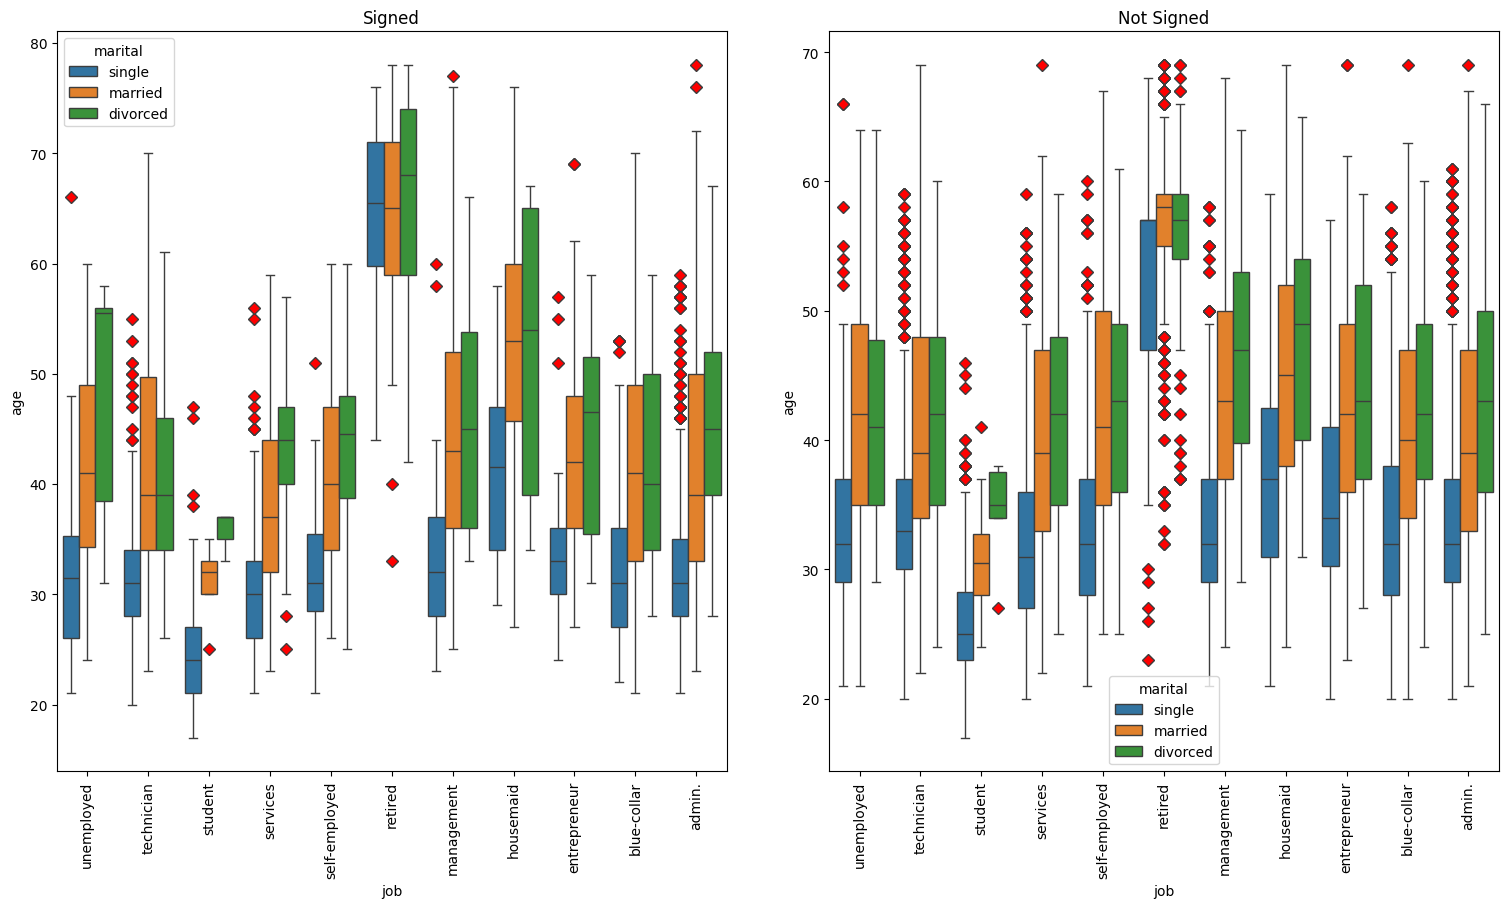

In [29]:
# continuous and categorical variables

numeric_vs_categorical_analysis(df0, df1, "age", "job", "marital")

**Retirees in the 'Signed' group look interesting, their age is significantly higher, yet they still subscribed to term deposits.**

count   mean  std    min    25%    50%    75%    max
marital  age_cats                                                      
divorced 20-30     18.00 -43.83 3.11 -47.10 -46.20 -44.45 -41.85 -36.10
         30-40    135.00 -41.11 5.17 -50.80 -46.20 -42.00 -36.40 -29.80
         40-50    126.00 -40.59 5.36 -50.80 -46.20 -40.60 -36.40 -29.80
         50-60    112.00 -39.31 6.23 -50.80 -42.70 -40.80 -34.35 -26.90
         60-70     25.00 -39.32 7.44 -50.80 -47.10 -38.30 -34.80 -26.90

count   mean  std    min    25%    50%    75%    max
marital  age_cats                                                       
divorced 20-30     211.00 -41.10 3.96 -47.10 -42.70 -42.00 -36.40 -26.90
         30-40    1370.00 -41.05 4.18 -50.80 -42.70 -42.00 -36.40 -26.90
         40-50    1422.00 -40.73 4.04 -50.80 -42.70 -41.80 -36.40 -26.90
         50-60    1038.00 -40.68 4.04 -50.80 -42.70 -42.00 -36.40 -26.90
         60-70      30.00 -37.78 8.03 -50.80 -46.88 -34.20 -31.40 -26.90

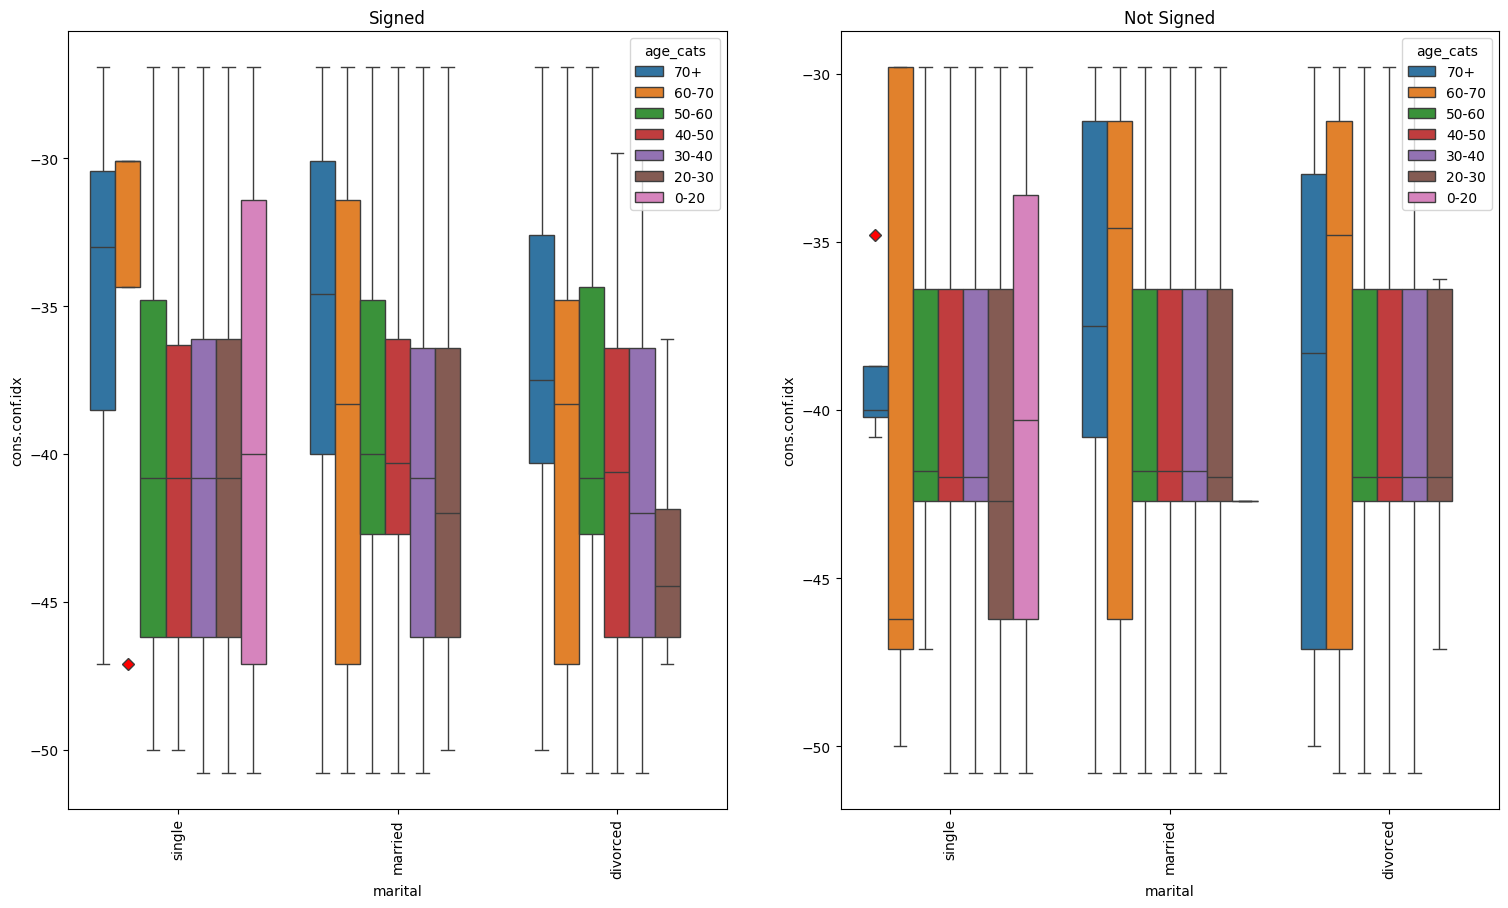

In [30]:
numeric_vs_categorical_analysis(df0, df1, "cons.conf.idx", "marital", "age_cats") 

**Single and older individuals show higher confidence levels. Younger divorced clients have lower values, meaning they react more pessimistically to the economy and are therefore less likely to subscribe.**

count   mean  std    min    25%    50%    75%    max
education job                                                               
basic     admin.        66.00 -41.13 5.26 -50.00 -46.20 -42.35 -40.00 -26.90
          blue-collar  470.00 -41.98 4.54 -50.80 -46.20 -42.70 -39.80 -26.90
          entrepreneur  28.00 -39.85 4.90 -46.20 -42.70 -40.80 -36.40 -29.80
          housemaid     59.00 -36.77 5.34 -47.10 -40.30 -36.10 -33.00 -26.90
          management    26.00 -38.10 7.02 -50.00 -42.70 -38.10 -30.43 -26.90

count   mean  std    min    25%    50%    75%    max
education job                                                                
basic     admin.        766.00 -40.71 4.17 -50.80 -42.70 -41.80 -36.40 -26.90
          blue-collar  6897.00 -41.33 4.07 -50.80 -46.20 -42.00 -36.40 -26.90
          entrepreneur  390.00 -41.11 3.96 -50.00 -42.70 -42.00 -36.40 -26.90
          housemaid     586.00 -39.49 4.03 -50.00 -42.70 -41.80 -36.10 -26.90
          management    325.00 -40.66 4.17 -50.00 -42.70 -41.80 -36.40 -26.90

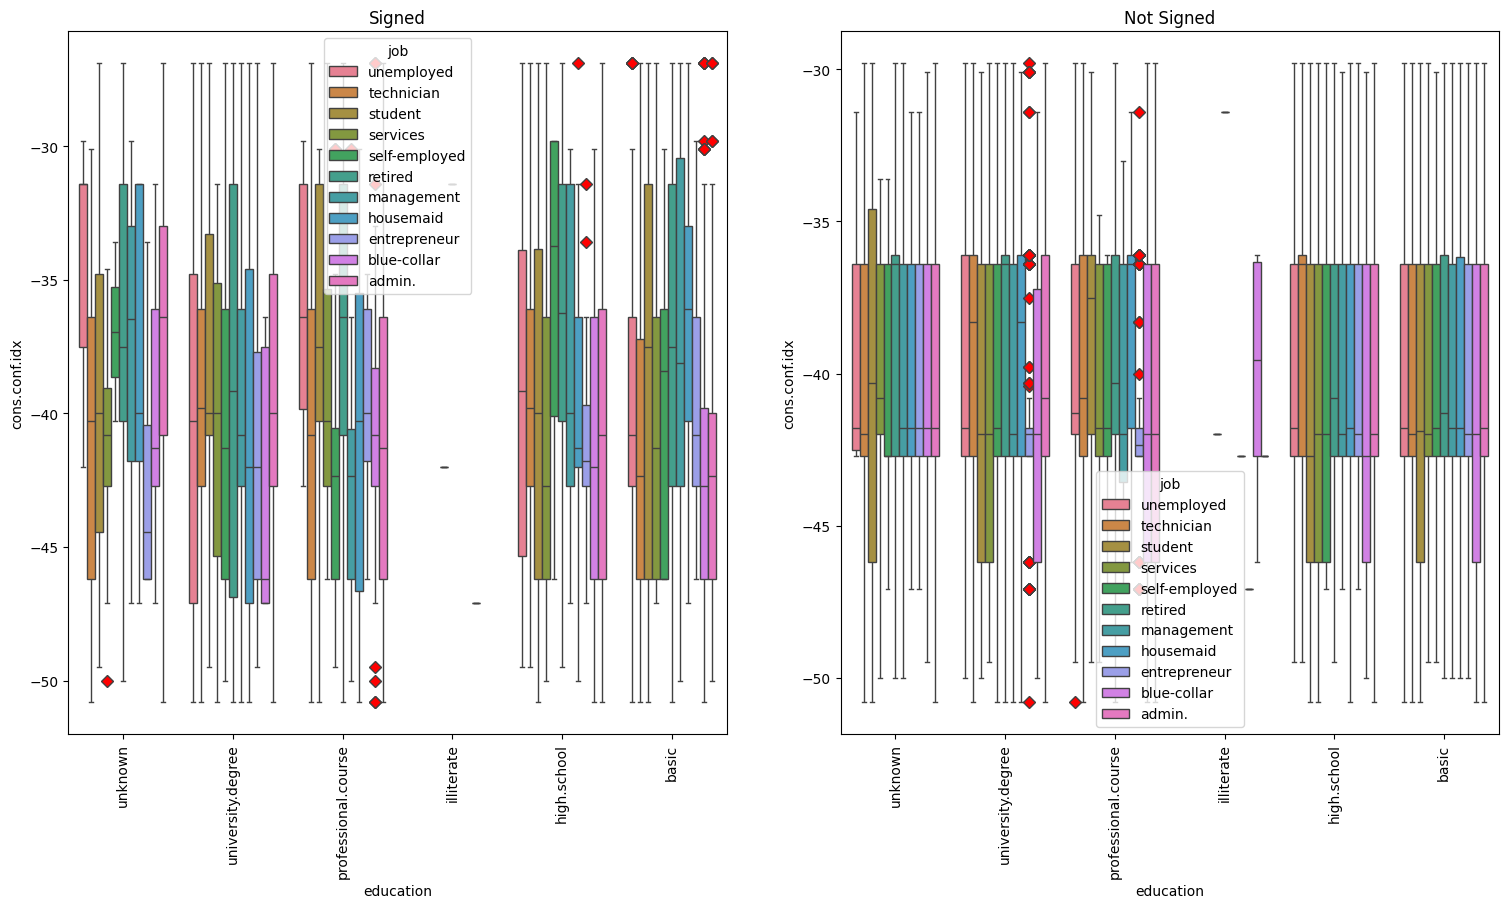

In [31]:
numeric_vs_categorical_analysis(df0, df1, "cons.conf.idx", "education", "job")

**The cons.conf.idx (consumer confidence) values are higher among subscribed clients with high school education. For blue-collar and admin. jobs, confidence is lower and fewer subscriptions are observed.**

In [32]:
def bi_countplot_target(df0, df1, column, hue_column) :
    group_name = f'Normalized distribution of values by category: {column}'
    print (group_name.upper())

    pltname = 'Client who subscribed'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)

    proportions = df1.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

    # annotation of values in bar plot
    for container in ax.containers:
      ax. bar_label(container, fmt='{:,.1f}%')

    pltname = 'Client who did not subscribe'
    unique_hue_values = df0[hue_column].unique()

    proportions = df0.groupby(hue_column)[column].value_counts (normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
    by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

    plt.show()

    #------------
    group_name = f'Number of values per category {column}'
    print(group_name.upper())

    pltname = 'Client who subscribed'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)
    counts = df1.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values [0], ascending=False
      ).plot.bar(ax=axes [0], title=pltname )

    for container in ax.containers:
      ax.bar_label(container)

    pltname = 'Client who did not subscribe'
    unique_hue_values = df0[hue_column].unique()
    counts = df0.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values (
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax. containers:
      ax.bar_label(container)

    plt.show()

NORMALIZED DISTRIBUTION OF VALUES BY CATEGORY: CONTACT


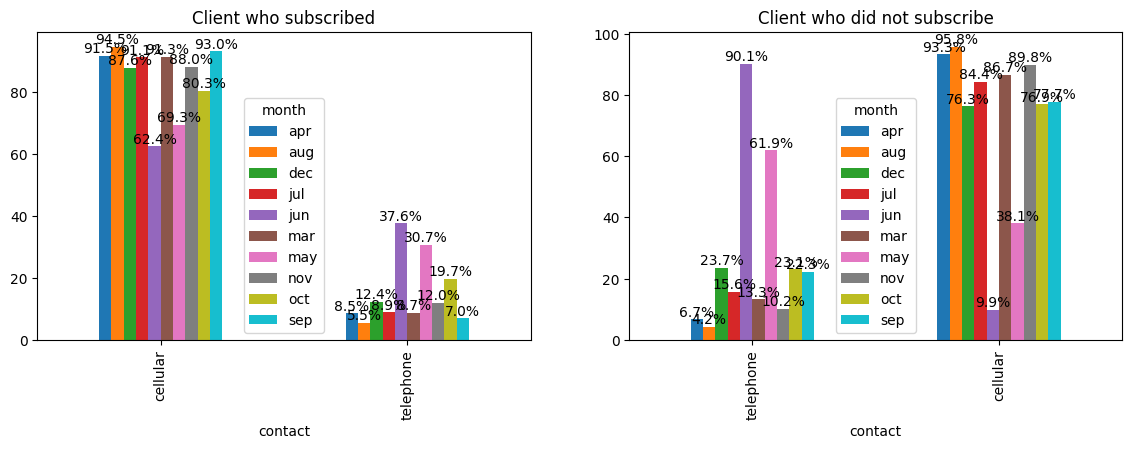

NUMBER OF VALUES PER CATEGORY CONTACT


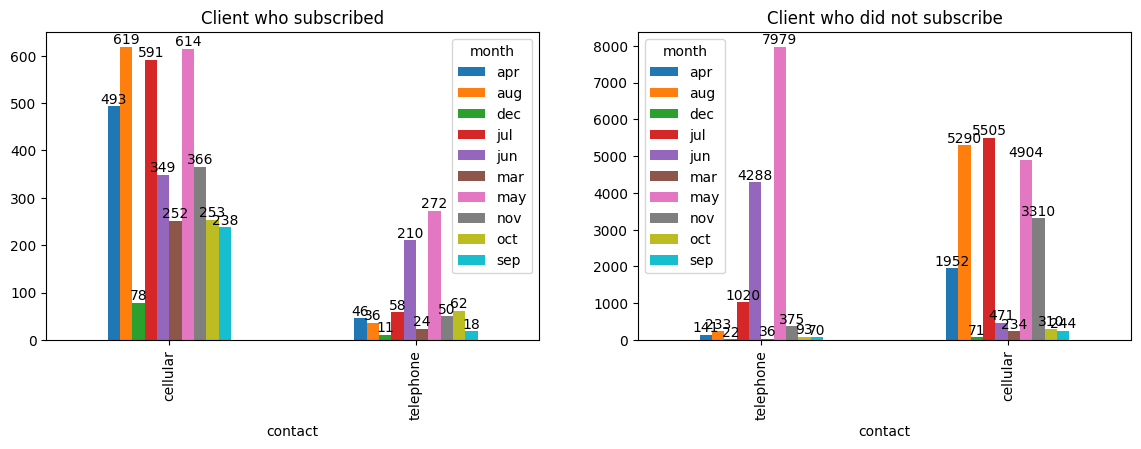

In [33]:
# categorical and categorical variables

bi_countplot_target(df0, df1, 'contact','month')

**Interestingly, phone calls in May and June were part of an especially large campaign, but at the same time they were ineffective, resulting in many refusals.**

**Hypotheses**

- campaign: Too many contacts reduce conversion; 1–2 calls work best.

- pdays / previous / no_prev_contact: The fact of no previous contact (no_prev_contact = 1) matters more than the actual value of pdays. Clients with a successful past contact (poutcome = success) are more likely to subscribe.

- emp.var.rate, euribor3m, nr.employed: These features are highly collinear. Lower interest rates and weaker labor markets correlate with more subscriptions.

- cons.conf.idx: Higher consumer confidence slightly increases the probability of subscription.

- contact: The cellular channel increases the chance of subscription, while telephone contacts in May/June represent an anti-pattern (many refusals).

- poutcome: A past success strongly increases the likelihood of subscription.

- job, education, marital, age / age_cats: Sociodemographic features have moderate predictive power; interactions matter more than individual variables.

- housing, loan: Financial burden (mortgage/loans) does not significantly affect subscription propensity.

- day_of_week: Much less important compared to month.

# Main part

**Modeling Methods**

Based on the nature of the task and insights from EDA, several approaches are appropriate:

- Logistic Regression — a simple, interpretable model that allows hypothesis testing; regularization (L1/L2) is advisable to address multicollinearity.

- Decision Trees / Ensemble Models — capable of capturing nonlinear relationships and feature interactions; more robust to outliers and class imbalance.

- Handling Imbalance — since the dataset is highly imbalanced, it is important to use stratified sampling in cross-validation and consider techniques such as oversampling (SMOTE) or setting class_weight='balanced' in models.

**Evaluation Metrics**

Because of the strong class imbalance, standard accuracy is not suitable. More appropriate metrics include:

- ROC-AUC as a main metric for model selection; measures the ability to distinguish between class 1 and class 0 across thresholds, useful for comparing models.

- Precision, Recall, F1-score (Recall is especially important, since the business goal is not to miss potential clients likely to subscribe; F1-score balances precision and recall, making it suitable for evaluating the final model).

In [34]:
X = df.drop(columns=['y', 'pdays_nan'])   
y = df['y']

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

# for Logistic Regression: exclude emp.var.rate and nr.employed (keep euribor3m)

num_cols_lr = [c for c in num_cols if c not in ['emp.var.rate', 'nr.employed']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


preprocessor_lr = ColumnTransformer([
    ('num', StandardScaler(), num_cols_lr),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

preprocessor_knn = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

preprocessor_tree = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])


models = {
    "Logistic Regression": Pipeline([
        ('preproc', preprocessor_lr),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2'))
    ]),
    
    "kNN": Pipeline([
        ('preproc', preprocessor_knn),
        ('clf', KNeighborsClassifier(n_neighbors=15))
    ]),
    
    "Decision Tree": Pipeline([
        ('preproc', preprocessor_tree),
        ('clf', DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, class_weight='balanced'))
    ]),
    
    "XGBoost": Pipeline([
        ('preproc', preprocessor_tree),
        ('clf', XGBClassifier(
            n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8,
            colsample_bytree=0.8, eval_metric='logloss', use_label_encoder=False,
            scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])
        ))
    ])
}


results = []

for name, model in models.items():
    print("="*50)
    print(f"Model: {name}")
    
    # training
    model.fit(X_train, y_train)
    
    # predictions on train
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(y_train, y_proba_train)
    
    # predictions on val
    y_pred_val = model.predict(X_val)
    y_proba_val = model.predict_proba(X_val)[:,1]
    auc_val = roc_auc_score(y_val, y_proba_val)
    
    # validation report
    print(f"ROC-AUC train: {auc_train:.3f}")
    print(f"ROC-AUC val:   {auc_val:.3f}")
    print(classification_report(y_val, y_pred_val))
    
    # saving to results
    results.append({
        "Model": name,
        "Hyperparameters": str(model.named_steps['clf']),
        "ROC-AUC train": auc_train,
        "ROC-AUC val": auc_val
    })

# creatibg results table
results_df = pd.DataFrame(results).sort_values(by="ROC-AUC val", ascending=False)
display(results_df)

Model: Logistic Regression
ROC-AUC train: 0.935
ROC-AUC val:   0.943
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7310
           1       0.45      0.90      0.60       928

    accuracy                           0.87      8238
   macro avg       0.72      0.88      0.76      8238
weighted avg       0.93      0.87      0.88      8238

Model: kNN
ROC-AUC train: 0.948
ROC-AUC val:   0.924
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.69      0.41      0.51       928

    accuracy                           0.91      8238
   macro avg       0.81      0.69      0.73      8238
weighted avg       0.90      0.91      0.90      8238

Model: Decision Tree
ROC-AUC train: 0.945
ROC-AUC val:   0.945
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7310
           1       0.43      0.92      0.59       92

,Model,Hyperparameters,ROC-AUC train,ROC-AUC val
3,XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.97,0.95
2,Decision Tree,DecisionTreeClassifier(class_weight='balanced'...,0.94,0.94
0,Logistic Regression,"LogisticRegression(class_weight='balanced', ma...",0.93,0.94
1,kNN,KNeighborsClassifier(n_neighbors=15),0.95,0.92


In [35]:
results_detailed = [
    {
        "Model": "XGBoost",
        "Hyperparameters": "n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, scale_pos_weight≈7.9",
        "ROC-AUC train": 0.971,
        "ROC-AUC val": 0.953,
        "Comment": "Best model: strong generalization, maintains high recall (0.92). Precision is somewhat lower (0.48), but acceptable given the business goal. Further tuning of n_estimators and learning_rate is recommended."
    },
    {
        "Model": "Decision Tree",
        "Hyperparameters": "max_depth=6, min_samples_leaf=50, class_weight=balanced",
        "ROC-AUC train": 0.945,
        "ROC-AUC val": 0.945,
        "Comment": "Good balance, but risk of overfitting due to sensitivity to hyperparameters. Captures class 1 well (recall=0.92). Can be extended into Random Forest or Gradient Boosting."
    },
    {
        "Model": "Logistic Regression",
        "Hyperparameters": "penalty=L2, class_weight=balanced, max_iter=1000",
        "ROC-AUC train": 0.935,
        "ROC-AUC val": 0.943,
        "Comment": "Interpretable model with stable metrics. Recall is high (0.90), but precision is low (0.45). Works well as a baseline model. Testing L1 regularization would be useful."
    },
    {
        "Model": "kNN",
        "Hyperparameters": "n_neighbors=15",
        "ROC-AUC train": 0.948,
        "ROC-AUC val": 0.924,
        "Comment": "Higher train AUC, but recall drops significantly (0.41) for class 1, making it unsuitable for imbalanced data. Testing other distance metrics or a larger k could help."
    }
]

# creating DataFrame
results_table = pd.DataFrame(results_detailed)

pd.set_option('display.max_colwidth', None)

display(results_table)

,Model,Hyperparameters,ROC-AUC train,ROC-AUC val,Comment
0,XGBoost,"n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, scale_pos_weight≈7.9",0.97,0.95,"Best model: strong generalization, maintains high recall (0.92). Precision is somewhat lower (0.48), but acceptable given the business goal. Further tuning of n_estimators and learning_rate is recommended."
1,Decision Tree,"max_depth=6, min_samples_leaf=50, class_weight=balanced",0.94,0.94,"Good balance, but risk of overfitting due to sensitivity to hyperparameters. Captures class 1 well (recall=0.92). Can be extended into Random Forest or Gradient Boosting."
2,Logistic Regression,"penalty=L2, class_weight=balanced, max_iter=1000",0.94,0.94,"Interpretable model with stable metrics. Recall is high (0.90), but precision is low (0.45). Works well as a baseline model. Testing L1 regularization would be useful."
3,kNN,n_neighbors=15,0.95,0.92,"Higher train AUC, but recall drops significantly (0.41) for class 1, making it unsuitable for imbalanced data. Testing other distance metrics or a larger k could help."


In [36]:
param_dist = {
    "clf__n_estimators": randint(100, 500),
    "clf__max_depth": randint(3, 10),
    "clf__learning_rate": uniform(0.01, 0.3),
    "clf__subsample": uniform(0.6, 0.4),
    "clf__colsample_bytree": uniform(0.6, 0.4),
    "clf__gamma": uniform(0, 5)
}

random_search = RandomizedSearchCV(
    estimator=models["XGBoost"],  
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters (RandomizedSearchCV):")
print(random_search.best_params_)
print("ROC-AUC train:", roc_auc_score(y_train, random_search.predict_proba(X_train)[:,1]))
print("ROC-AUC val:", roc_auc_score(y_val, random_search.predict_proba(X_val)[:,1]))

Best parameters (RandomizedSearchCV):
{'clf__colsample_bytree': 0.7088528997538541, 'clf__gamma': 3.238450602706812, 'clf__learning_rate': 0.010156113098594747, 'clf__max_depth': 7, 'clf__n_estimators': 332, 'clf__subsample': 0.7219125032632117}
ROC-AUC train: 0.9638270125114695
ROC-AUC val: 0.95476290155196


**A very balanced model with a low learning rate, better generalization, and no clear overfitting, kept as a strong baseline.**

In [37]:
space = {
    "n_estimators": hp.quniform("n_estimators", 100, 500, 25),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "subsample": hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
    "gamma": hp.uniform("gamma", 0, 5)
}

def objective(params):
    
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    
    
    model = Pipeline([
        ('preproc', preprocessor_tree),
        ('clf', XGBClassifier(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            learning_rate=params["learning_rate"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            gamma=params["gamma"],
            eval_metric='logloss',
            use_label_encoder=False,
            scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])
        ))
    ])
    

    score = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc", n_jobs=-1).mean()
    
    return {"loss": -score, "status": STATUS_OK}


trials = Trials()
best_hyperopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials, rstate=np.random.default_rng(42), show_progressbar=False)

print("Best parameters (Hyperopt):", best_hyperopt)

Best parameters (Hyperopt): {'colsample_bytree': 0.96098438227139, 'gamma': 3.2270942835921983, 'learning_rate': 0.013594100414947104, 'max_depth': 9.0, 'n_estimators': 225.0, 'subsample': 0.6685637358882779}


In [38]:
best_params = {
    "n_estimators": int(best_hyperopt["n_estimators"]),
    "max_depth": int(best_hyperopt["max_depth"]),
    "learning_rate": best_hyperopt["learning_rate"],
    "subsample": best_hyperopt["subsample"],
    "colsample_bytree": best_hyperopt["colsample_bytree"],
    "gamma": best_hyperopt["gamma"],
}

xgb_hyperopt = Pipeline([
    ('preproc', preprocessor_tree),
    ('clf', XGBClassifier(
        **best_params,
        eval_metric="logloss",
        use_label_encoder=False,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42
    ))
])

xgb_hyperopt.fit(X_train, y_train)

y_proba_train = xgb_hyperopt.predict_proba(X_train)[:,1]
y_proba_val = xgb_hyperopt.predict_proba(X_val)[:,1]

print("ROC-AUC train:", roc_auc_score(y_train, y_proba_train))
print("ROC-AUC val:", roc_auc_score(y_val, y_proba_val))

ROC-AUC train: 0.973733642714606
ROC-AUC val: 0.9539517636445115


**Slightly higher train AUC (risk of overfitting), but validation AUC is almost identical to RandomizedSearch. It seems Hyperopt pushed the model toward greater complexity.**

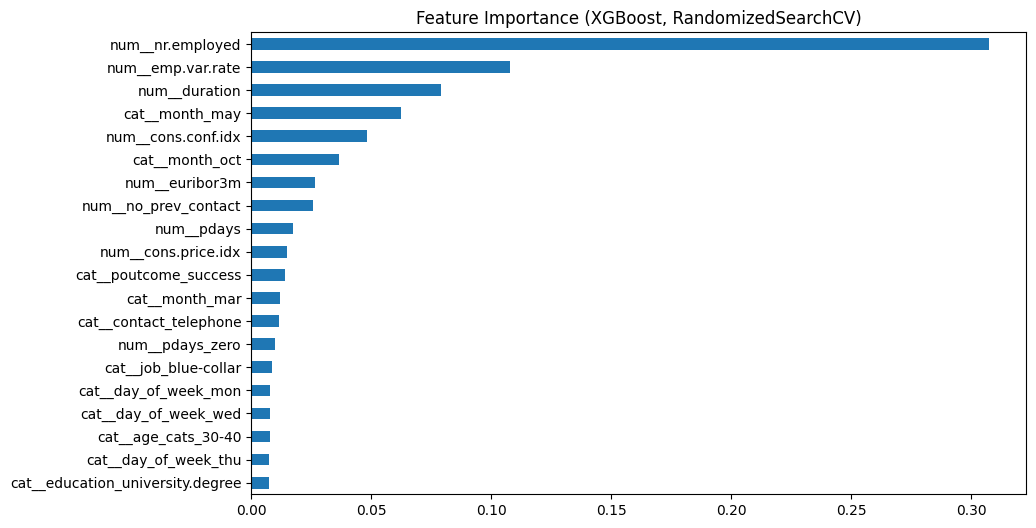

num__nr.employed                   0.31
num__emp.var.rate                  0.11
num__duration                      0.08
cat__month_may                     0.06
num__cons.conf.idx                 0.05
cat__month_oct                     0.04
num__euribor3m                     0.03
num__no_prev_contact               0.03
num__pdays                         0.02
num__cons.price.idx                0.01
cat__poutcome_success              0.01
cat__month_mar                     0.01
cat__contact_telephone             0.01
num__pdays_zero                    0.01
cat__job_blue-collar               0.01
cat__day_of_week_mon               0.01
cat__day_of_week_wed               0.01
cat__age_cats_30-40                0.01
cat__day_of_week_thu               0.01
cat__education_university.degree   0.01
dtype: float32

In [39]:
# taking the better model from RandomizedSearchCV
best_xgb = random_search.best_estimator_

xgb_clf = best_xgb.named_steps['clf']

feature_names = (
    best_xgb.named_steps['preproc']
    .get_feature_names_out()
)

importances = pd.Series(xgb_clf.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(20).plot(kind='barh')
plt.title("Feature Importance (XGBoost, RandomizedSearchCV)")
plt.gca().invert_yaxis()
plt.show()

importances.head(20)

**Observations**

- nr.employed - a macro indicator of employment. Logically, when the labor market is strong (more people employed), clients are less inclined to open deposits. It makes sense that this feature ranks near the top.

- emp.var.rate - during economic downturns, people are more likely to place money into safe deposits.

- duration - important but not suitable for production, since it is only known after the call.

- month_may - reflects seasonality; May campaigns were the most intensive, but not always effective.

- cons.conf.idx - lower consumer confidence slightly increases the likelihood of deposits.

- pdays - noisy due to many 999 values; a simpler “was contacted / was not contacted” flag is more reliable.

- poutcome_success - previous campaign success should intuitively be a strong predictor, but its importance is lower, possibly due to correlations with other features.

Overall, macroeconomic variables, seasonality, and consumer confidence rank high in importance, while weekdays and demographics fall to the bottom which is logical and consistent with expectations.

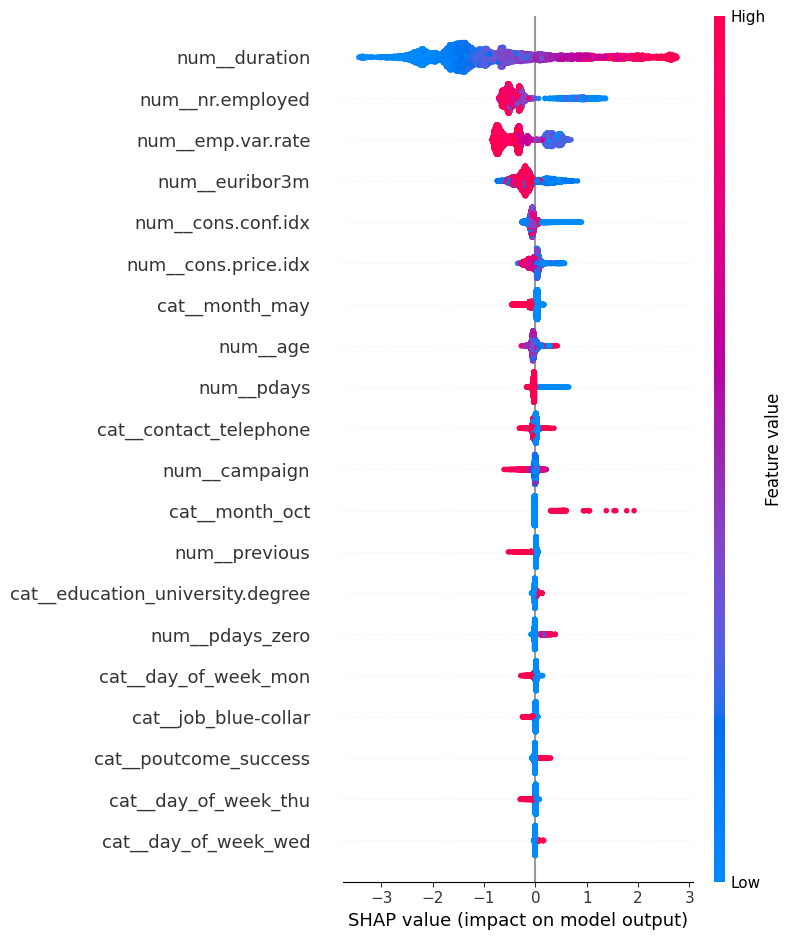

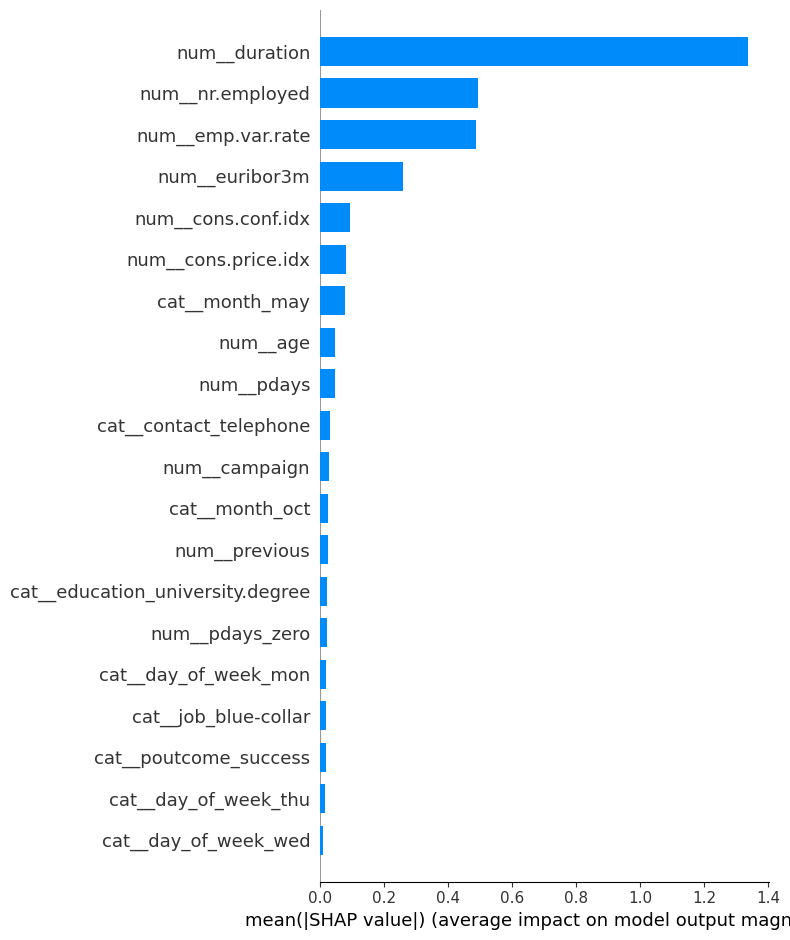

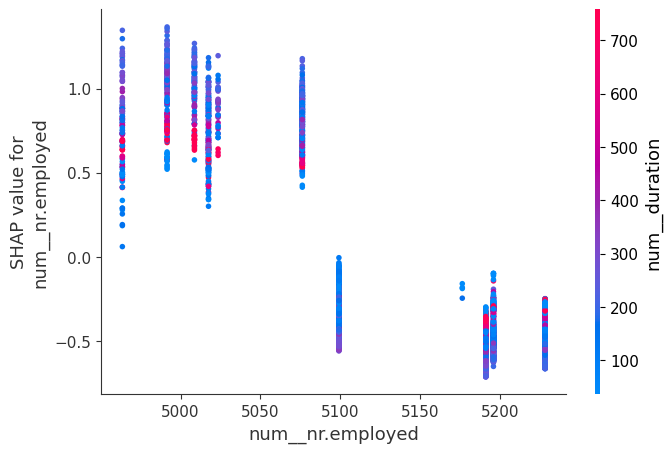

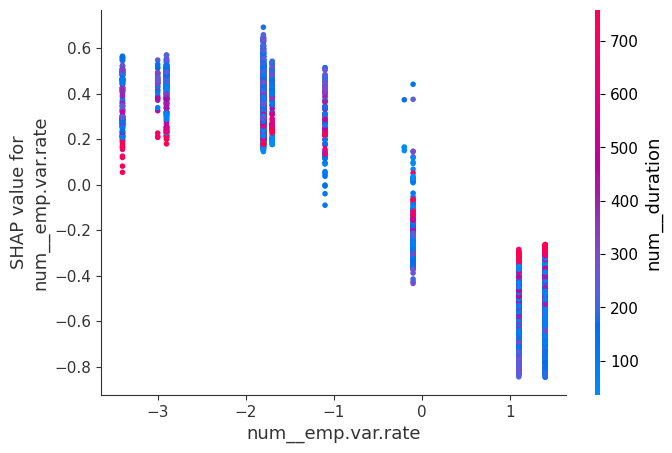

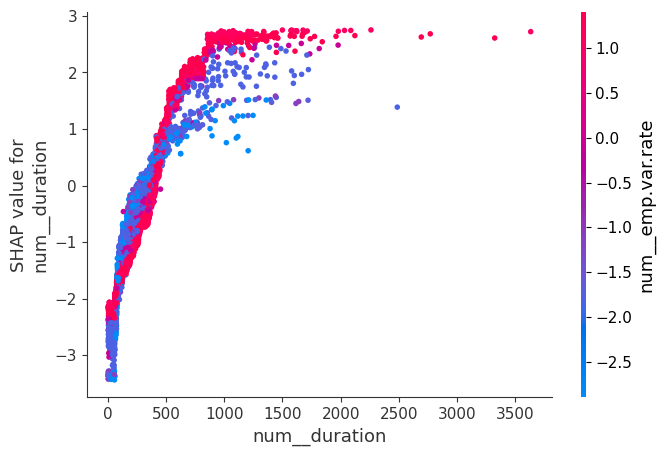

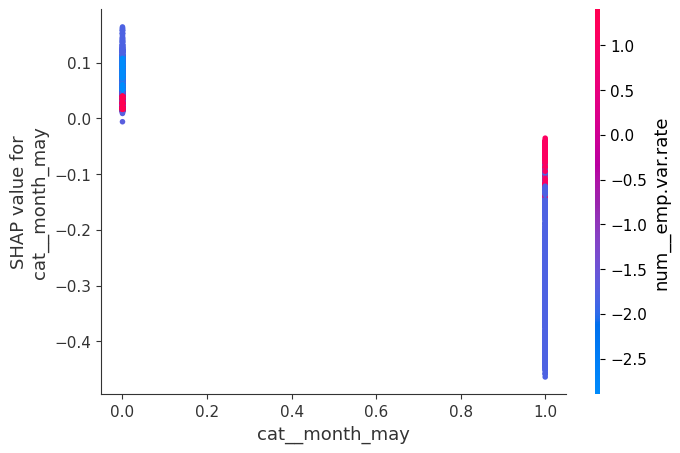

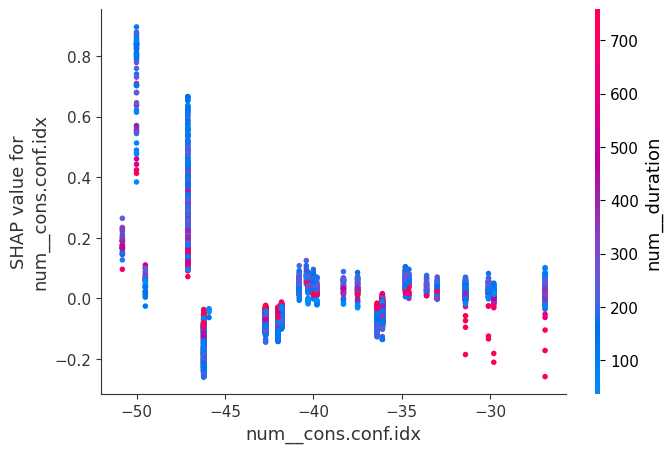

In [40]:
best_model = random_search.best_estimator_

preprocessor = best_model.named_steps['preproc']
xgb_clf = best_model.named_steps['clf']

# transforming input data
X_val_transformed = preprocessor.transform(X_val)
feature_names = preprocessor.get_feature_names_out()

# initializing explainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_val_transformed)

# summary plot (global feature importance)
shap.summary_plot(shap_values, X_val_transformed, feature_names=feature_names)

# beeswarm plot
shap.summary_plot(shap_values, X_val_transformed, feature_names=feature_names, plot_type="bar")

# dependence plot for top features
top_features = pd.Series(xgb_clf.feature_importances_, index=feature_names).sort_values(ascending=False).head(5).index
for feat in top_features:
    shap.dependence_plot(feat, shap_values, X_val_transformed, feature_names=feature_names)

**SHAP confirmed the results of the EDA. The key factor is contact duration, followed by macroeconomic context (employment, interest rates, growth/decline) and seasonality (month, especially May). Sociodemographic variables (job, education, marital) play a secondary role. This aligns with common sense, as the model captured exactly the signals that realistically influence client behavior.**

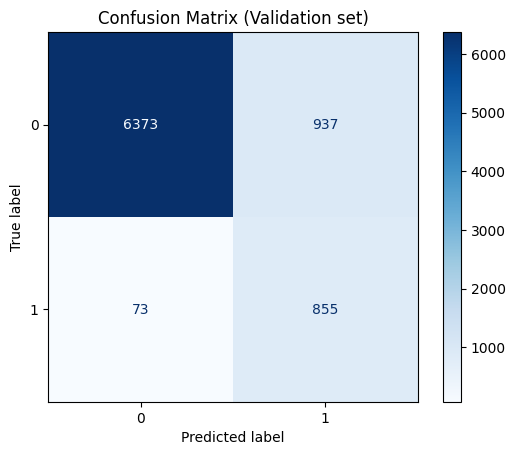

False Positives: 937
False Negatives: 73

=== JOB ===
False Positives:
job
admin.        0.30
technician    0.16
blue-collar   0.14
retired       0.09
management    0.08
Name: proportion, dtype: float64
False Negatives:
job
blue-collar   0.26
admin.        0.23
technician    0.14
management    0.10
services      0.08
Name: proportion, dtype: float64

=== EDUCATION ===
False Positives:
education
university.degree     0.37
basic                 0.25
high.school           0.20
professional.course   0.12
unknown               0.06
Name: proportion, dtype: float64
False Negatives:
education
university.degree     0.32
basic                 0.29
high.school           0.22
professional.course   0.15
unknown               0.03
Name: proportion, dtype: float64

=== CONTACT ===
False Positives:
contact
cellular    0.77
telephone   0.23
Name: proportion, dtype: float64
False Negatives:
contact
cellular    0.70
telephone   0.30
Name: proportion, dtype: float64

=== MONTH ===
False Positives:
month


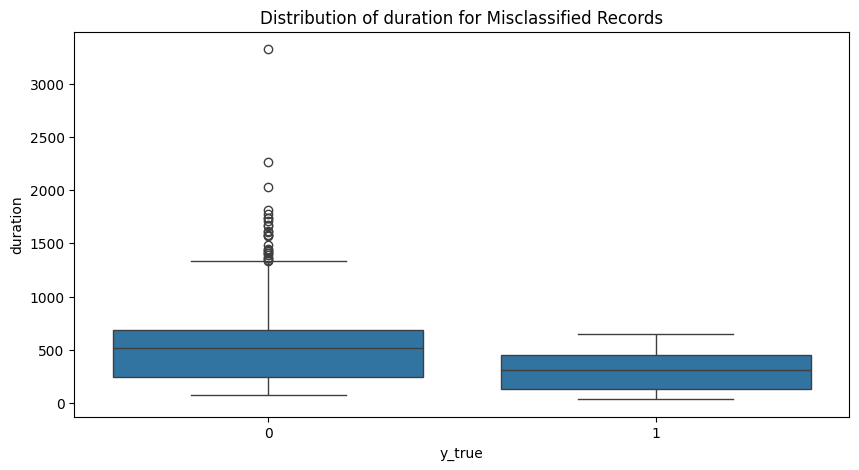

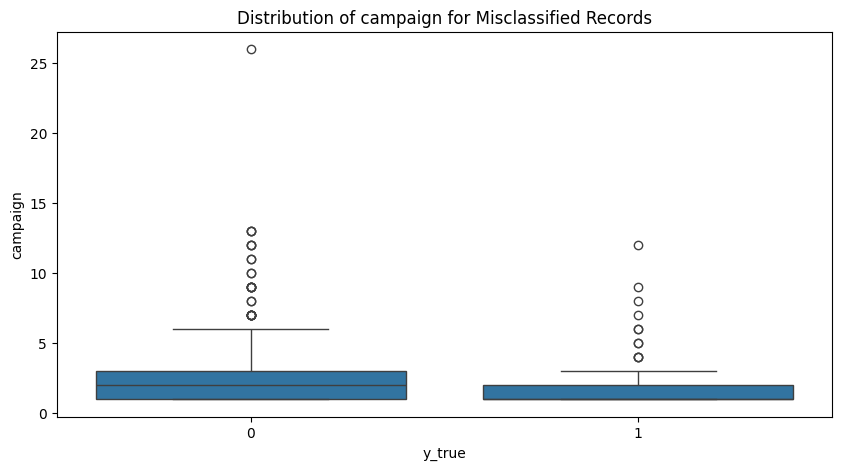

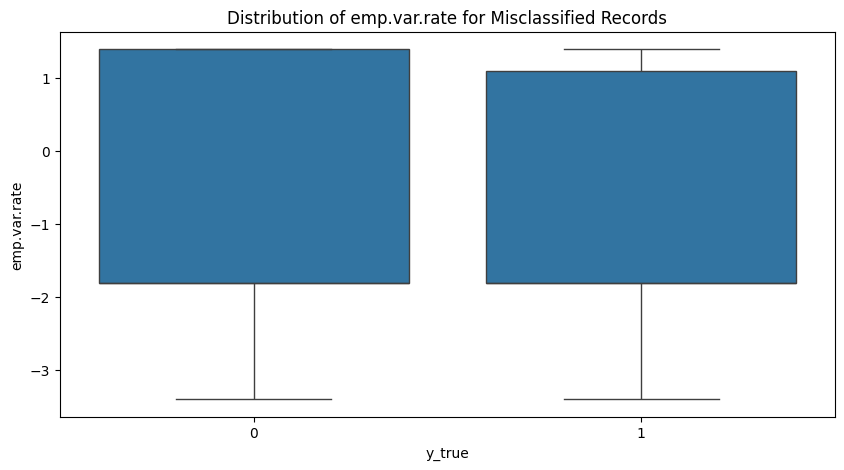

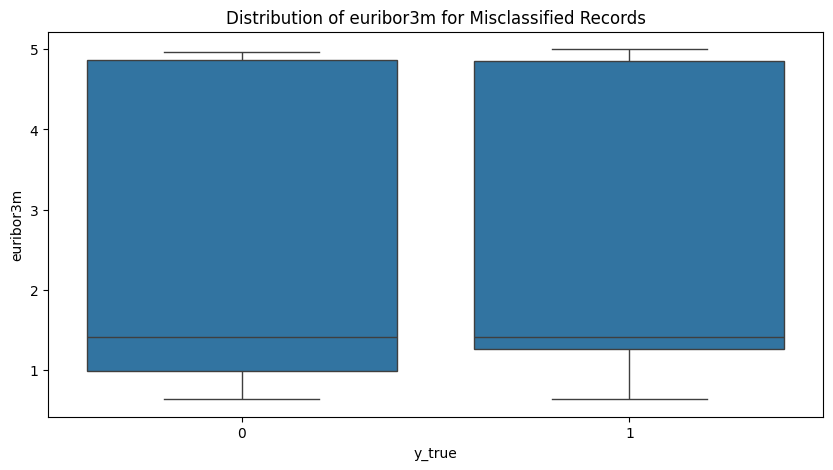

In [41]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation set)")
plt.show()

val_results = X_val.copy()
val_results["y_true"] = y_val
val_results["y_pred"] = y_pred_val
val_results["y_proba"] = y_proba_val

false_positives = val_results[(val_results["y_true"] == 0) & (val_results["y_pred"] == 1)]
false_negatives = val_results[(val_results["y_true"] == 1) & (val_results["y_pred"] == 0)]

print("False Positives:", false_positives.shape[0])
print("False Negatives:", false_negatives.shape[0])

# categorical variables

for col in ["job", "education", "contact", "month"]:
    print(f"\n=== {col.upper()} ===")
    print("False Positives:")
    print(false_positives[col].value_counts(normalize=True).head())
    print("False Negatives:")
    print(false_negatives[col].value_counts(normalize=True).head())

# numerical variables

num_vars = ["duration", "campaign", "emp.var.rate", "euribor3m"]
for col in num_vars:
    plt.figure(figsize=(10,5))
    sns.boxplot(x="y_true", y=col, data=val_results[val_results["y_true"] != val_results["y_pred"]])
    plt.title(f"Distribution of {col} for Misclassified Records")
    plt.show()

**Problem**

- The model produces many false positives (FPs) — it is overly optimistic in predicting that clients will subscribe.

- Numerical features: in macroeconomic data, the model does not always capture whether a client will respond to a deposit.

- Categorical features: confusion is frequent for admin., technician, and blue-collar; also for clients with either university or basic education, and those contacted via cellular.

- Seasonality: May is particularly problematic, as large-scale campaigns in this month resulted in high error rates.

**Possible Improvements**

- Class balancing: adjust the decision threshold upward so the model predicts fewer false "yes" cases.

- Feature engineering: limit the impact of duration, transform campaign into categorical groups (1 call, 2–3 calls, 4+ calls)

- More flexible models: explore ensembles such as Stacking (Logistic Regression + Tree-based models + XGBoost).

- Metric tuning: if the business goal is to minimize false positives, optimize Precision-Recall instead of ROC-AUC.